## **Mobile Health Assignment 2**

This Google Colab notebook contains your second assigment.

Copy this Colab notebook into your own Google Drive. Please fill in code where required in your copy, and answer the questions on a written report (Word, Google Doc, LaTeX -- or anything else you prefer). The word limit for the written report Part II students is 1200 words and for Part III/MPhil/CDT students it is 1800 words.

For a faster runtime, you can use a T4 GPU runtime instance available in Colab by clicking *Runtime > Change runtime type > T4 GPU hardware accelerator*. Please be careful to only use a GPU runtime when you are actively running the code, as Colab has limits on the usage of GPU runtimes. For experimental purposes, you can first connect to a CPU runtime.

When you see this symbol ❓, you need to answer the relevant question. Please add your implementations in this Colab notebook and write your answer in your report / answer sheet. If your report needs to refer to a plot or result from Colab, make sure to also include it in the report. Code implementations need not be included in the report, but need to be present in the Colab.

The final questions in Q4 and Q5 are conceptual. To answer them, you may need to get inspiration from research papers (with citation), and you need to show your depth of understanding to the application at hand. To better explain your answers to any of the given questions you may use schematic diagrams and/or paper references.

### Submission Ιnstructions:
You need to submit both the Colab notebook and your PDF report / answer sheet as follows:
1. Use the share option (top right) in Colab to get a publicly sharable link. Put it in a *.txt* file named *colab_link.txt*
2. Download the Colab as a *.ipynb* file and name it *colab_notebook.ipynb*
3. Save the written report as a *.pdf* file named *report.pdf*
4. Put all the three files above in a *.zip* file named *your blind grading number* (Part II students) or *your CRSid* (Part III / MPhill students) and upload it to [Moodle](https://www.vle.cam.ac.uk/course/view.php?id=252668) by the deadline

**Important:** Please cite all the code/text/sources used in your ideation and implementation, as noted in the lab's [guide](https://www.cst.cam.ac.uk/teaching/exams/plagiarism).

Please post any questions related to this assignment on the relevant [Moodle Forum](https://www.vle.cam.ac.uk/mod/hsuforum/view.php?id=18990113), so that everyone can benefit from the answers. Kindly note that all questions will need to be posted by the 14th of March 2024 at noon (i.e., one day before the assignment's deadline). Please refrain from asking questions over email.

If you have additional questions, you may visit during the office hours for assignment 2 as follows:

* 05/03/2024: 3:00 - 4:00 PM in room FW26 (after lecture)
* 12/03/2024: 3:00 - 4:00 PM in room FW26 (no lecture, only office hour)

The deadline for submitting this assignment on Moodle is the **15th of March 2024 at noon**.

# Q1: IMU Data Loading, Exploration, Pre-Processing, and Balancing
[10 marks]

This question focuses on data loading, exploration, pre-processing, and balancing techniques, enabling you to explore and understand the IMU dataset used in this assignment.

1.1❓ Visualise the time series data for the user with *user_id = 11* in their session *session = 0*. Note that the data was collected at a sampling rate of *50Hz*, and the acceleration unit is *g = 9.81m/s^2*. **Important:** implement the relevant `plot_accelerometer_timeseries` function, but do not change the function definition provided. [5]

1.2❓ Visualise the label distributions in the training, validation, and test data. Briefly discuss the implications, if any, that the distributions you visualise may have on the model training. [5]

## Importing Relevant Libraries

In [103]:

import tensorflow as tf
import requests
import zipfile
import itertools
import os
import re
import glob
import sklearn.model_selection
import sklearn.metrics
from statistics import mode
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#additional imports
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score,balanced_accuracy_score
import joblib
from tqdm import tqdm
from pathlib import Path

## Loading the Dataset

### Download Data and Unzip

Here we use the `requests` module to download the data set hosted on GitHub, and we unzip it using the `zipfile` module.

In [2]:
file_url = "https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip?raw=true"
dataset_file_name = "B_Accelerometer_data.zip"
data_directory = "data"
accelerometer_data_folder_path = "data/B_Accelerometer_data/B_Accelerometer_data"

r = requests.get(file_url)
with open(dataset_file_name, 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(data_directory, dataset_file_name.split(".")[0]))

### Load Data into Memory

We then load the accelerometer data into memory, taking care of the structure of the unzipped files.

The structure of the dataset is as follows:
```
data
+-- B_Accelerometer_data
    +-- B_Accelerometer_data
        +-- dws_1
        +-- dws_11
            +-- sub_1.csv
            +-- sub_10.csv
            +-- sub_11.csv
            ...
        +-- dws_2
        +-- jog_16
        ...
```
Where `dws`, `jog` corresponds to the activities labels, and the `ids` in `sub_[id].csv` corresponds to the user id.

This function loads the data into a user-separated format, where `user_split_datasets` is a python dictionary with keys corresponding to the user id, and the values are lists of triaxial accelerometer timeseries and labels. We use lists instead of a single numpy array because series are not contiguous.

We also keep a record of all the labels in the dataset.

In [3]:
label_set = {}
user_split_datasets = {}
all_trials_folders = sorted(glob.glob(accelerometer_data_folder_path + "/*"))

# Loop through every trial folder
for trial_folder in all_trials_folders:
    trial_name = os.path.split(trial_folder)[-1]

    # label of the trial is given in the folder name, separated by underscore
    label = trial_name.split("_")[0]
    label_set[label] = True
    print(trial_folder)

    # Loop through files for every user of the trail
    for trial_user_file in sorted(glob.glob(trial_folder + "/*.csv")):

        # use regex to match the user id
        user_id_match = re.search(r'(?P<user_id>[0-9]+)\.csv', os.path.split(trial_user_file)[-1])
        if user_id_match is not None:
            user_id = int(user_id_match.group('user_id'))

            # Read file
            user_trial_dataset = pd.read_csv(trial_user_file)
            user_trial_dataset.dropna(how = "any", inplace = True)

            # Extract the x, y, z channels
            values = user_trial_dataset[["x", "y", "z"]].values

            # the label is the same during the entire trial, so it is repeated here to pad to the same length as the values
            labels = np.repeat(label, values.shape[0])

            if user_id not in user_split_datasets:
                user_split_datasets[user_id] = []
            user_split_datasets[user_id].append((values, labels))
        else:
            print("[ERR] User id not found", trial_user_file)

label_list = list(label_set.keys())
user_split_datasets.keys()

data/B_Accelerometer_data/B_Accelerometer_data/dws_1
data/B_Accelerometer_data/B_Accelerometer_data/dws_11
data/B_Accelerometer_data/B_Accelerometer_data/dws_2
data/B_Accelerometer_data/B_Accelerometer_data/jog_16
data/B_Accelerometer_data/B_Accelerometer_data/jog_9
data/B_Accelerometer_data/B_Accelerometer_data/sit_13
data/B_Accelerometer_data/B_Accelerometer_data/sit_5
data/B_Accelerometer_data/B_Accelerometer_data/std_14
data/B_Accelerometer_data/B_Accelerometer_data/std_6
data/B_Accelerometer_data/B_Accelerometer_data/ups_12
data/B_Accelerometer_data/B_Accelerometer_data/ups_3
data/B_Accelerometer_data/B_Accelerometer_data/ups_4
data/B_Accelerometer_data/B_Accelerometer_data/wlk_15
data/B_Accelerometer_data/B_Accelerometer_data/wlk_7
data/B_Accelerometer_data/B_Accelerometer_data/wlk_8


dict_keys([1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 3, 4, 5, 6, 7, 8, 9])

In [4]:
# Print all labels
label_list

['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

In [5]:
# Display the structure of the dataset loaded
for user_id in user_split_datasets:
    all_seseions = [session[0].shape for session in user_split_datasets[user_id]]
    print(f"User {user_id} - {len(all_seseions)} sessions - [{all_seseions}]")

User 1 - 15 sessions - [[(1781, 3), (918, 3), (2500, 3), (1592, 3), (4927, 3), (10419, 3), (10419, 3), (2595, 3), (10322, 3), (1090, 3), (2233, 3), (3121, 3), (1359, 3), (5513, 3), (4400, 3)]]
User 10 - 15 sessions - [[(2722, 3), (1138, 3), (2935, 3), (1484, 3), (4462, 3), (5945, 3), (9517, 3), (3318, 3), (7242, 3), (1355, 3), (2549, 3), (3042, 3), (2297, 3), (6489, 3), (6195, 3)]]
User 11 - 15 sessions - [[(2062, 3), (994, 3), (2788, 3), (1011, 3), (3336, 3), (7751, 3), (8031, 3), (3020, 3), (11437, 3), (1176, 3), (2410, 3), (2829, 3), (1664, 3), (6714, 3), (4958, 3)]]
User 12 - 15 sessions - [[(1553, 3), (837, 3), (1939, 3), (1272, 3), (4599, 3), (2982, 3), (8155, 3), (2269, 3), (9426, 3), (1472, 3), (2289, 3), (2895, 3), (2659, 3), (6831, 3), (4929, 3)]]
User 13 - 15 sessions - [[(1616, 3), (577, 3), (1844, 3), (1055, 3), (3467, 3), (3325, 3), (10027, 3), (3958, 3), (12016, 3), (396, 3), (927, 3), (1544, 3), (1810, 3), (5540, 3), (3839, 3)]]
User 14 - 15 sessions - [[(1753, 3), (564

### Visualise the Data

1.1❓ Visualise the time series data for the user with *user_id = 11* in their session *session = 0*. Note that the data was collected at a sampling rate of *50Hz*, and the acceleration unit is *g = 9.81m/s^2*. **Important:** implement the relevant `plot_accelerometer_timeseries` function, but do not change the function definition provided. [5]

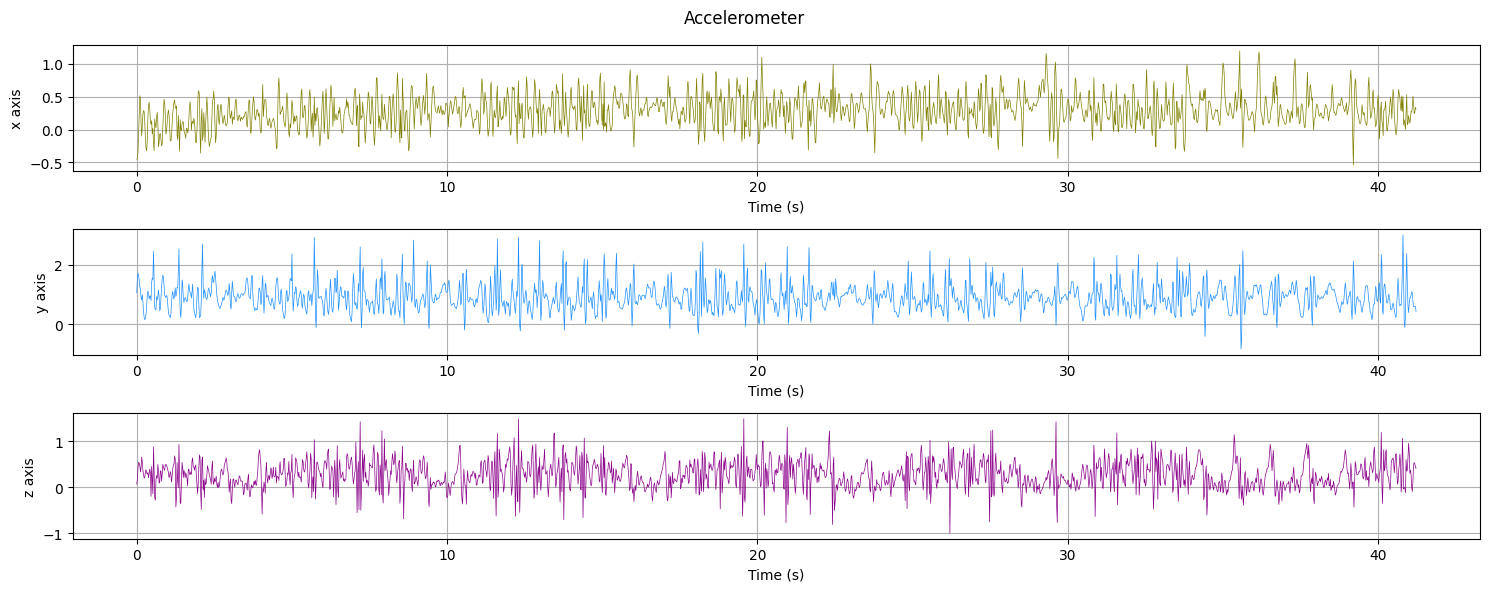

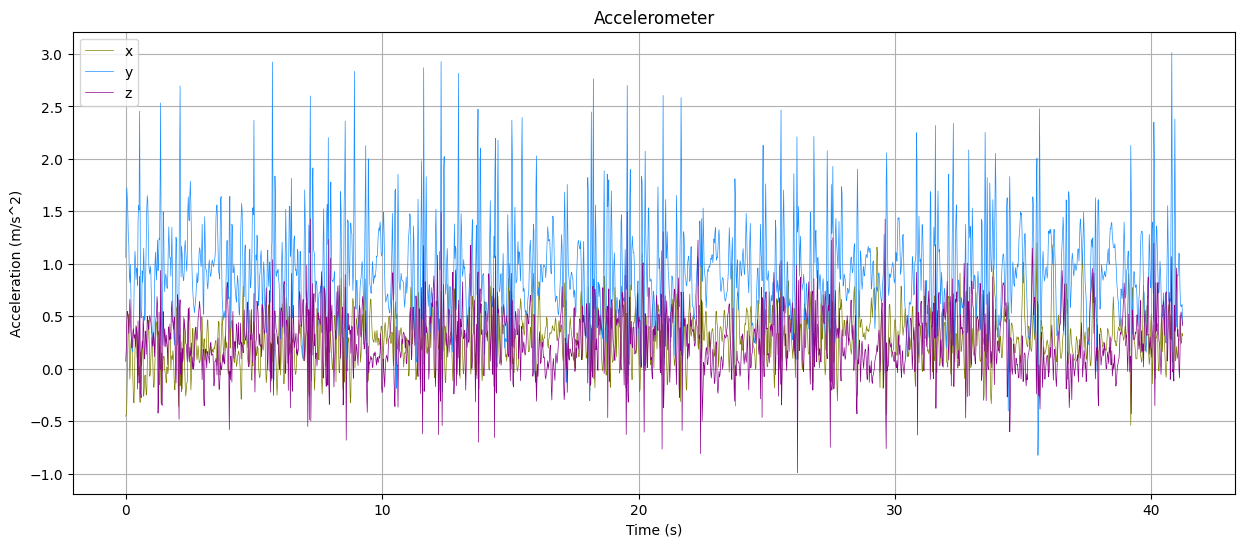

In [6]:
def plot_accelerometer_timeseries(timeseries, title = "", figsize = (15, 6), xlim = None):
    # X (horizontal), Y (vertical), and Z (depth)
    data = timeseries
    linewidth = 0.5
    colors = ['olive','dodgerblue','darkmagenta']
    labels = ['x','y','z']
    time = np.arange(len(data)) / 50

    plt.figure(figsize=figsize)
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(time, data[:, i], color=colors[i],linewidth=linewidth)
        #plt.title(f'acl {labels[i]}')
        plt.xlabel('Time (s)')
        plt.ylabel(f'{labels[i]} axis')
        plt.grid(True)
        if xlim is not None:
            plt.xlim(xlim)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=figsize)
    for i in range(3):
        plt.plot(time, data[:, i], color=colors[i],label=labels[i],linewidth=linewidth)

    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend()
    plt.grid(True)

plt.show()
    

user_id = 11
session = 0
(data,labels) = user_split_datasets[user_id][session] # 2062 data points times 3 dims x,y,z (data,labels)
plot_accelerometer_timeseries(data,title='Accelerometer')

## Pre-processing and Balancing the Dataset

Here we pre-process the dataset so that it is better fit for training a neural network. This involves six main steps:

1. Use a sliding window to make a windowed dataset
2. Split the dataset into a training and a test set
3. Normalise the datasets
4. Apply label encoding
5. Subdivide the training set into training and validation sets

### Sliding Window

First of all, we apply the sliding window processing step, to make fixed-sized window that can be used for input for a neural network. Here we use `window_size = 400` and `shift = window_size // 2` which produces windows of size 400 and 50% overlap.

For labels, we use majority voting to decide the label for the window, but other methods can also be used. Since we are using MotionSense, the activity label does not change within sessions, so it would not matter.

In [7]:
def get_mode(np_array):
    """
    Get the mode (majority/most frequent value) from a 1D array
    """
    return [mode(np_array)]

def sliding_window_np(X, window_size, shift, stride, offset=0, flatten=None):
    """
    Create sliding windows from an ndarray
    Parameters:

        X (numpy-array)
            The numpy array to be windowed

        shift (int)
            number of timestamps to shift for each window
            (200 here refers to 50% overlap, no overlap if =400)
        stride (int)
            stride of the window (dilation)
        offset (int)
            starting index of the first window

        flatten (function (array) -> (value or array) )
            the function to be applied to a window after it is extracted
            can be used with get_mode (see above) for extracting the label by majority voting
            ignored if is None
    Return:
        Windowed ndarray
            shape[0] is the number of windows
    """

    overall_window_size = (window_size - 1) * stride + 1
    num_windows = (X.shape[0] - offset - (overall_window_size)) // shift + 1
    windows = []
    for i in range(num_windows):
        start_index = i * shift + offset
        this_window = X[start_index : start_index + overall_window_size : stride]
        if flatten is not None:
            this_window = flatten(this_window)
        windows.append(this_window)
    return np.array(windows)

def get_windows_dataset_from_user_list_format(user_datasets, window_size=400, shift=200, stride=1, verbose=0):
    """
    Create windows dataset in 'user-list' format using sliding windows
    Parameters:
        user_datasets
            dataset in the 'user-list' format {user_id: [(sensor_values, activity_labels)]}

        window_size = 400
            size of the window (output)
        shift = 200
            number of timestamps to shift for each window
            (200 here refers to 50% overlap, no overlap if =400)
        stride = 1
            stride of the window (dilation)
        verbose = 0
            debug messages are printed if > 0

    Return:
        user_dataset_windowed
            Windowed version of the user_datasets
            Windows from different trials are combined into one array
            type: {user_id: ( windowed_sensor_values, windowed_activity_labels)}
            windowed_sensor_values have shape (num_window, window_size, channels)
            windowed_activity_labels have shape (num_window)
            Labels are decided by majority vote
    """

    user_dataset_windowed = {}

    for user_id in user_datasets:
        if verbose > 0:
            print(f"Processing {user_id}")
        x = []
        y = []

        # Loop through each trail of each user
        for v,l in user_datasets[user_id]:
            v_windowed = sliding_window_np(v, window_size, shift, stride)

            # Flatten the window by majority vote (1 value for each window)
            l_flattened = sliding_window_np(l, window_size, shift, stride, flatten = get_mode)
            if len(v_windowed) > 0:
                x.append(v_windowed)
                y.append(l_flattened)
            if verbose > 0:
                print(f"Data: {v_windowed.shape}, Labels: {l_flattened.shape}")

        # Combine all trials
        user_dataset_windowed[user_id] = (np.concatenate(x), np.concatenate(y).squeeze())
    return user_dataset_windowed

In [8]:
window_size = 400
user_datasets_windowed = get_windows_dataset_from_user_list_format(user_split_datasets, window_size=window_size, shift=window_size//2)

Now let's focus on the visualisation.

In [9]:
for user_id in user_datasets_windowed:
    print(f"User {user_id}\t - data shape = {user_datasets_windowed[user_id][0].shape} - label shape = {user_datasets_windowed[user_id][1].shape}")

User 1	 - data shape = (293, 400, 3) - label shape = (293,)
User 10	 - data shape = (280, 400, 3) - label shape = (280,)
User 11	 - data shape = (279, 400, 3) - label shape = (279,)
User 12	 - data shape = (248, 400, 3) - label shape = (248,)
User 13	 - data shape = (238, 400, 3) - label shape = (238,)
User 14	 - data shape = (263, 400, 3) - label shape = (263,)
User 15	 - data shape = (281, 400, 3) - label shape = (281,)
User 16	 - data shape = (311, 400, 3) - label shape = (311,)
User 17	 - data shape = (258, 400, 3) - label shape = (258,)
User 18	 - data shape = (297, 400, 3) - label shape = (297,)
User 19	 - data shape = (343, 400, 3) - label shape = (343,)
User 2	 - data shape = (292, 400, 3) - label shape = (292,)
User 20	 - data shape = (259, 400, 3) - label shape = (259,)
User 21	 - data shape = (327, 400, 3) - label shape = (327,)
User 22	 - data shape = (263, 400, 3) - label shape = (263,)
User 23	 - data shape = (252, 400, 3) - label shape = (252,)
User 24	 - data shape = (2

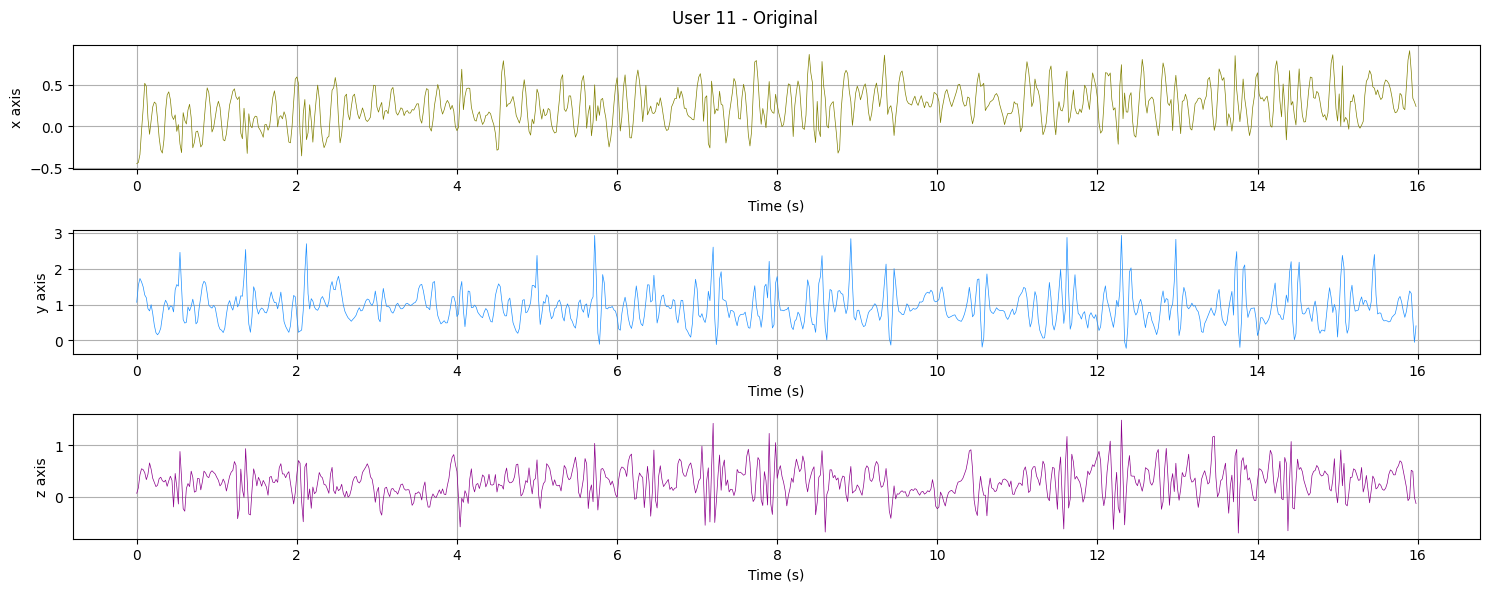

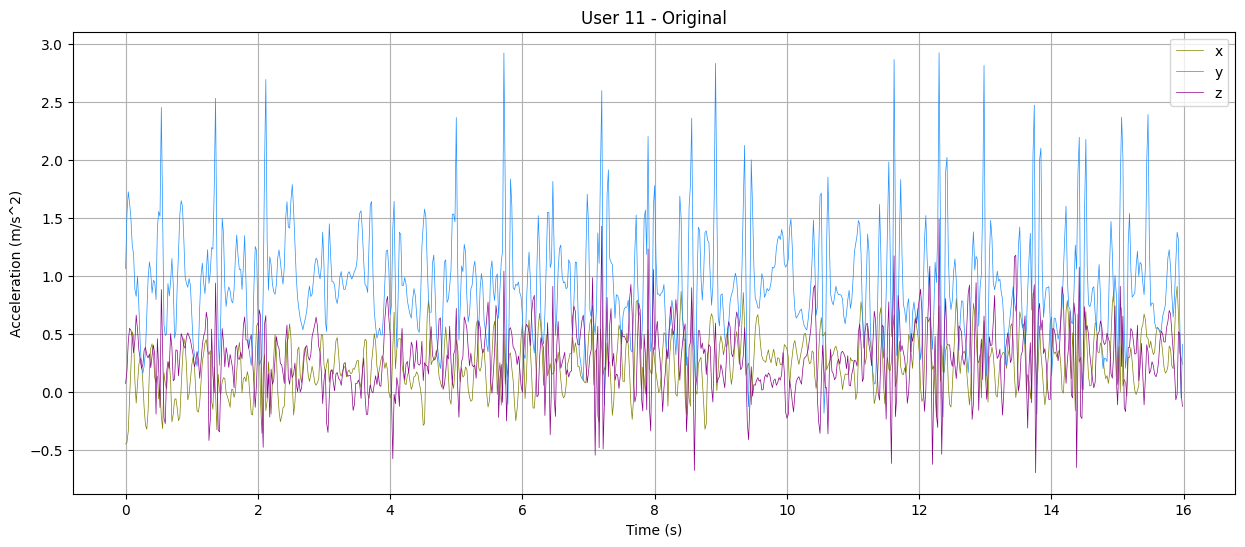

In [10]:
user_id = 11
plot_accelerometer_timeseries(user_split_datasets[user_id][0][0][:800], f"User {user_id} - Original", figsize=(15,6))

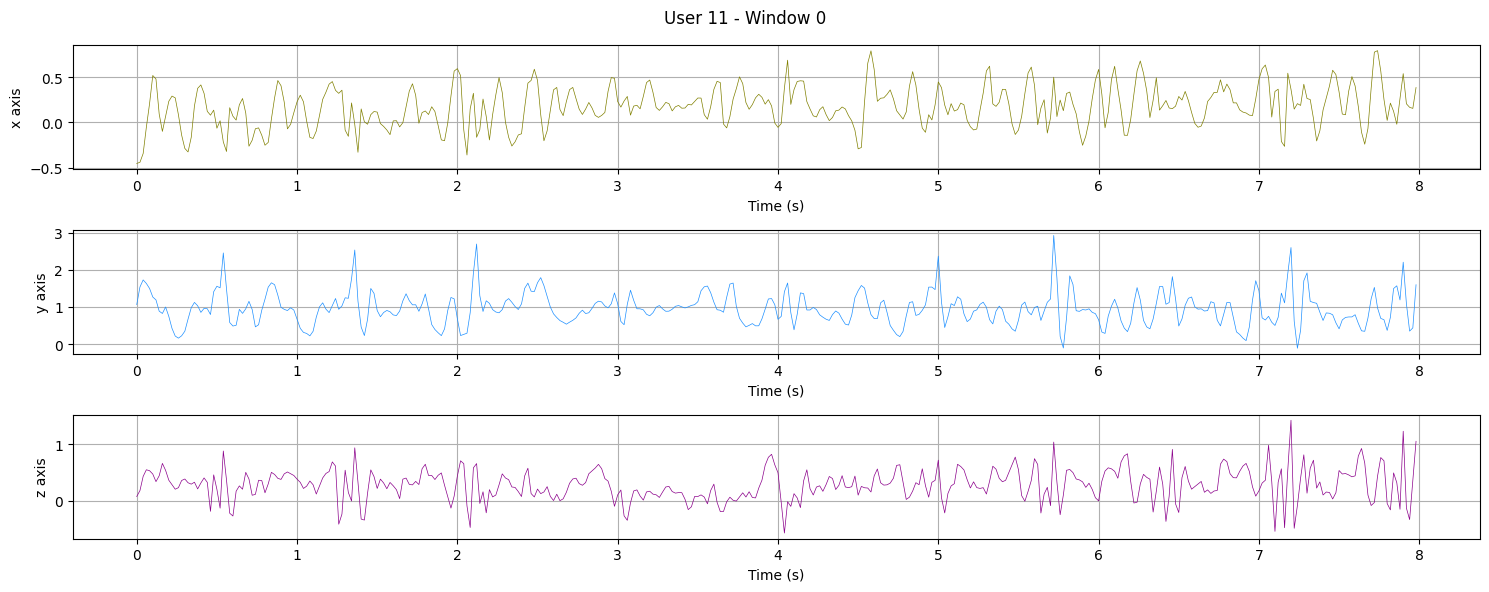

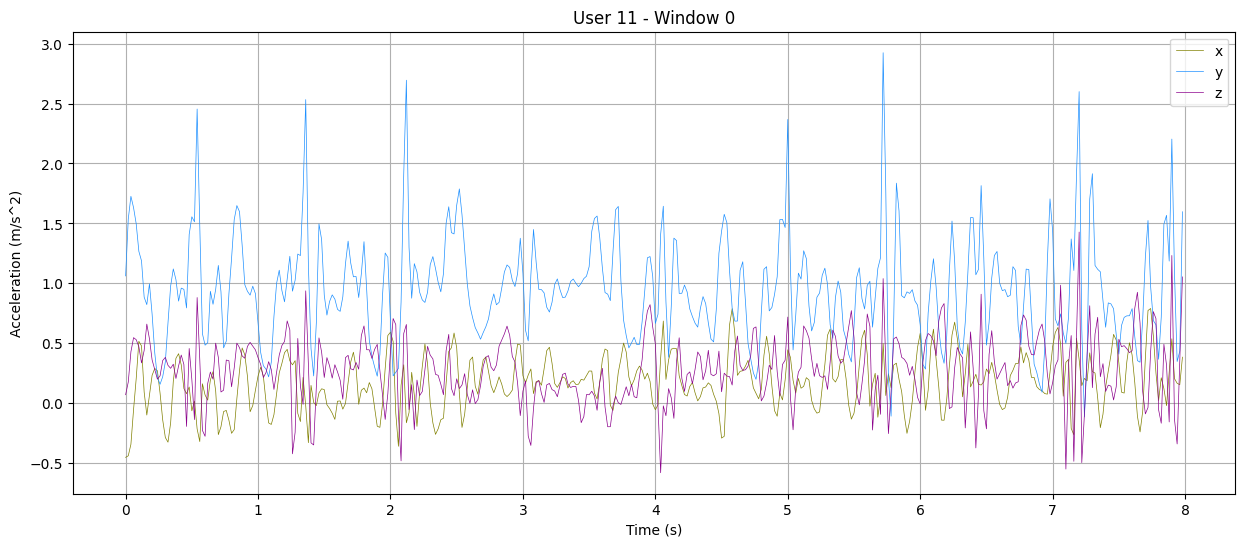

In [11]:
plot_accelerometer_timeseries(user_datasets_windowed[user_id][0][0], f"User {user_id} - Window 0", figsize=(15,6))

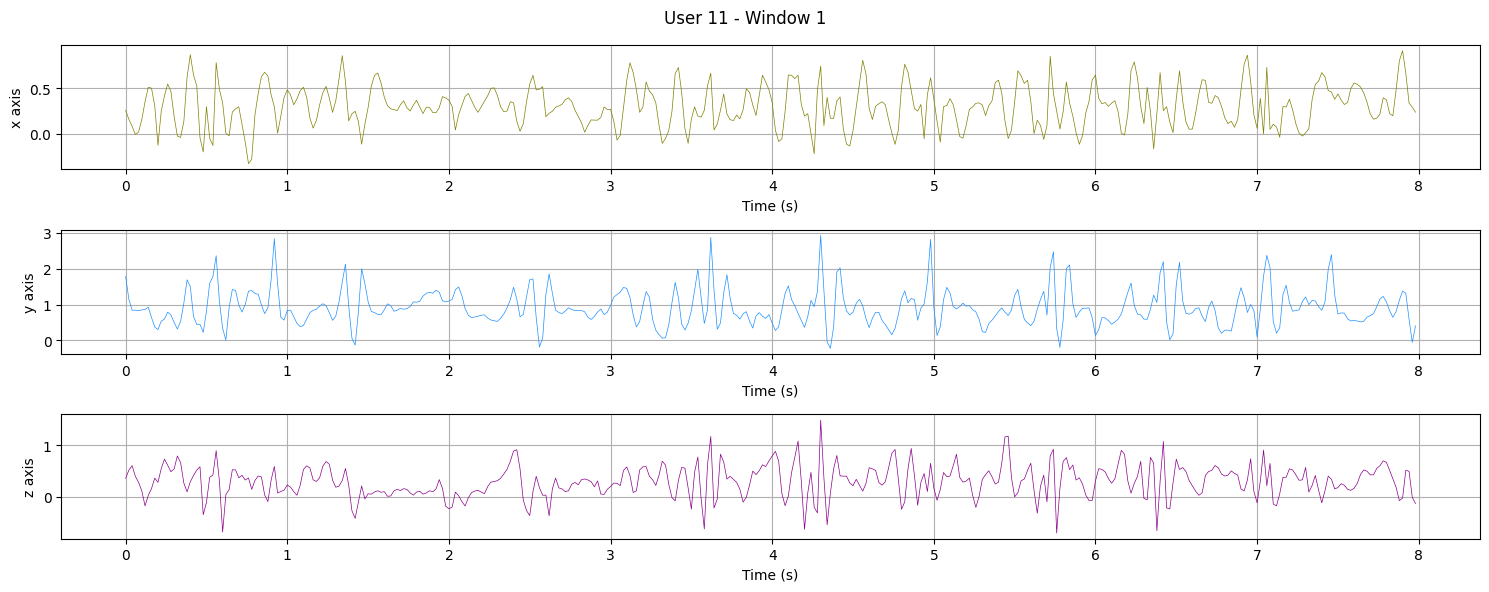

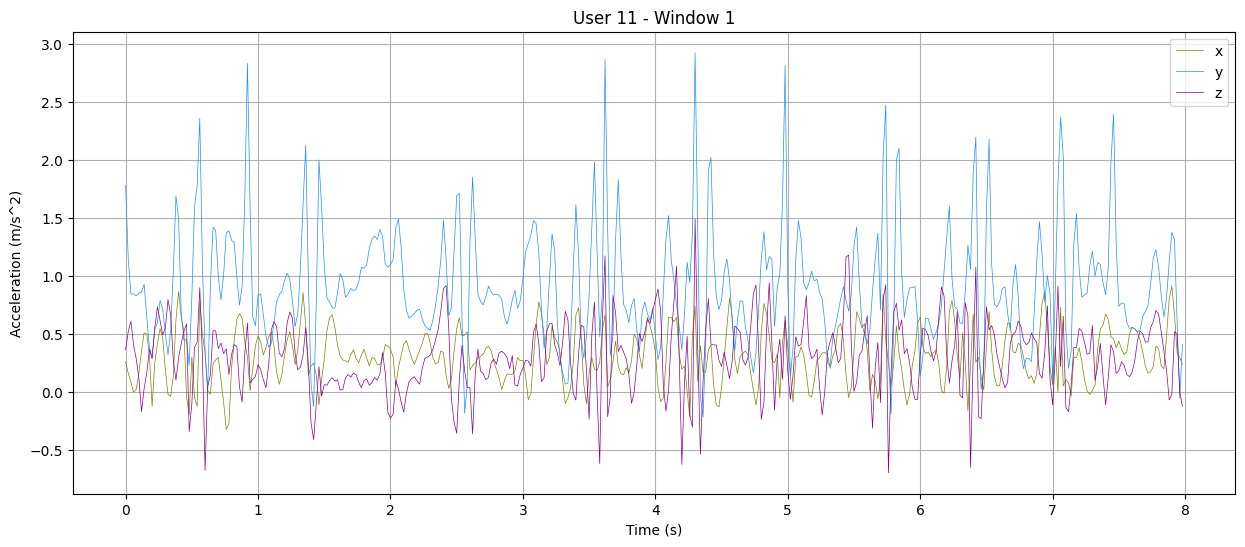

In [12]:
plot_accelerometer_timeseries(user_datasets_windowed[user_id][0][2], f"User {user_id} - Window 1", figsize=(15,6))

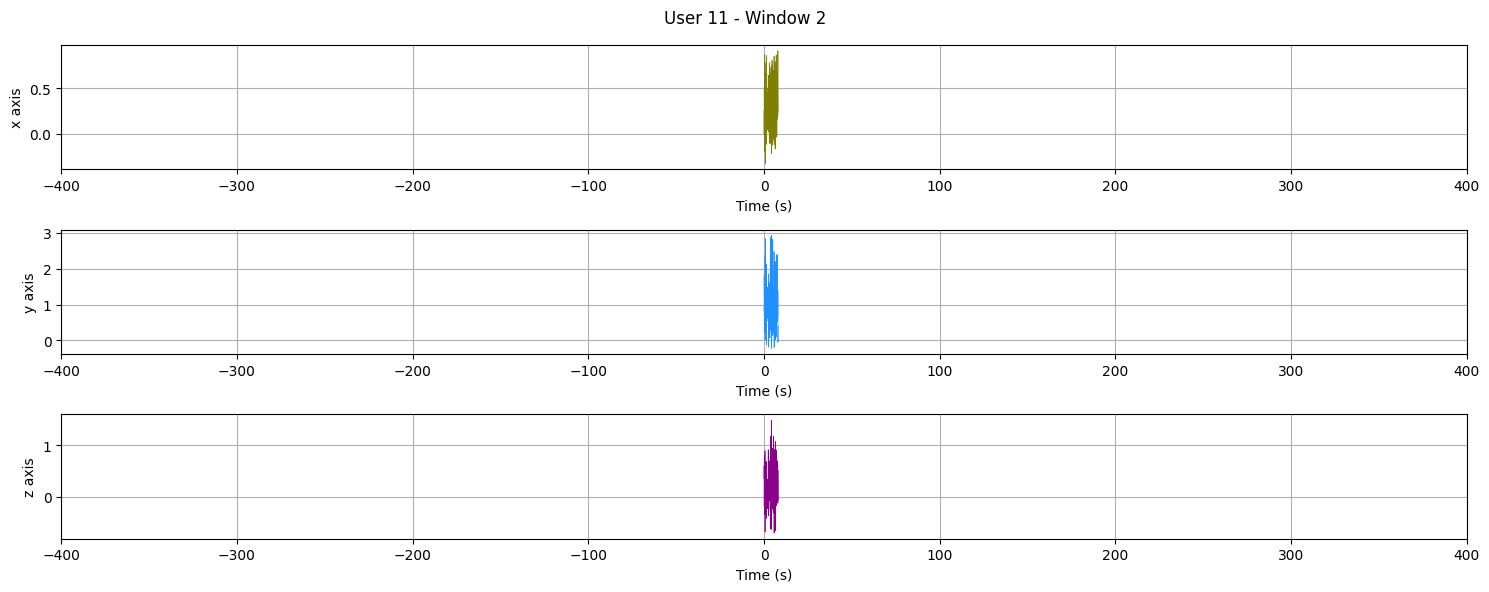

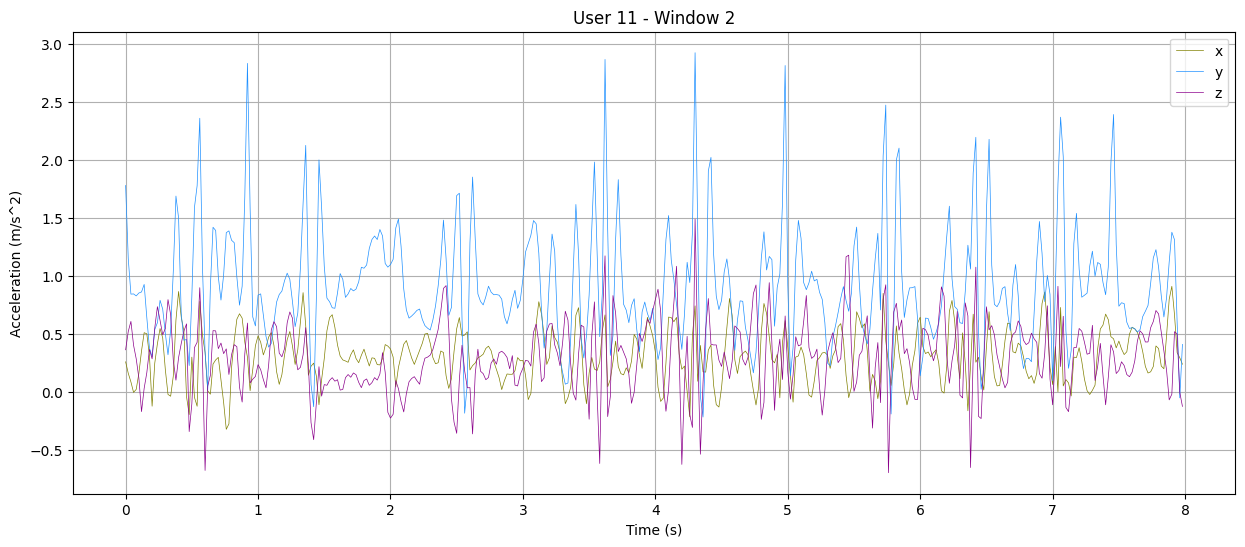

In [13]:
plot_accelerometer_timeseries(user_datasets_windowed[user_id][0][2], f"User {user_id} - Window 2", xlim=(-400,400), figsize=(15,6))

### Training & Testing Split

Here we perform a user-based split to separate dataset into training and testing sets, where data from a fixed set of users is reserved for testing, and the rest for training. This allows us to better evaluate the performance of the model in a more realistic scenario, where we test on new users instead of existing users.

In [14]:
# We take every 5 users to be testing users, starting from the first
har_users = list(user_split_datasets.keys())
test_users = har_users[0::5]
train_users = [u for u in har_users if u not in test_users]

print("Training Users:", train_users)
print("Testing Users: ", test_users)

Training Users: [10, 11, 12, 13, 15, 16, 17, 18, 2, 20, 21, 22, 24, 3, 4, 5, 7, 8, 9]
Testing Users:  [1, 14, 19, 23, 6]


In [15]:
def combine_windowed_dataset(user_datasets_windowed, train_users, test_users=None, verbose=0):
    """
    Combine a windowed 'user-list' dataset into training and test sets
    Parameters:
        user_dataset_windowed
            dataset in the windowed 'user-list' format {user_id: ( windowed_sensor_values, windowed_activity_labels)}

        train_users
            list or set of users (corresponding to the user_id) to be used as training data
        test_users = None
            list or set of users (corresponding to the user_id) to be used as testing data
            if is None, then all users not in train_users will be treated as test users
        verbose = 0
            debug messages are printed if > 0
    Return:
        (train_x, train_y, test_x, test_y)
            train_x, train_y
                the resulting training/test input values as a single numpy array
            test_x, test_y
                the resulting training/test labels as a single (1D) numpy array
    """

    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for user_id in user_datasets_windowed:

        v,l = user_datasets_windowed[user_id]
        if user_id in train_users:
            if verbose > 0:
                print(f"{user_id} Train")
            train_x.append(v)
            train_y.append(l)
        elif test_users is None or user_id in test_users:
            if verbose > 0:
                print(f"{user_id} Test")
            test_x.append(v)
            test_y.append(l)


    if len(train_x) == 0:
        train_x = np.array([])
        train_y = np.array([])
    else:
        train_x = np.concatenate(train_x)
        train_y = np.concatenate(train_y).squeeze()

    if len(test_x) == 0:
        test_x = np.array([])
        test_y = np.array([])
    else:
        test_x = np.concatenate(test_x)
        test_y = np.concatenate(test_y).squeeze()

    return train_x, train_y, test_x, test_y


In [16]:
train_x, train_y, test_x, test_y = combine_windowed_dataset(user_datasets_windowed, train_users, test_users)

In [17]:
print("Training set")
for user in train_users:
    print(f"+  {user_datasets_windowed[user][0].shape}\tSamples from User {user}")
print("--------------------------------------------")
print(f"=  {train_x.shape}\tSamples")

Training set
+  (280, 400, 3)	Samples from User 10
+  (279, 400, 3)	Samples from User 11
+  (248, 400, 3)	Samples from User 12
+  (238, 400, 3)	Samples from User 13
+  (281, 400, 3)	Samples from User 15
+  (311, 400, 3)	Samples from User 16
+  (258, 400, 3)	Samples from User 17
+  (297, 400, 3)	Samples from User 18
+  (292, 400, 3)	Samples from User 2
+  (259, 400, 3)	Samples from User 20
+  (327, 400, 3)	Samples from User 21
+  (263, 400, 3)	Samples from User 22
+  (238, 400, 3)	Samples from User 24
+  (295, 400, 3)	Samples from User 3
+  (262, 400, 3)	Samples from User 4
+  (244, 400, 3)	Samples from User 5
+  (287, 400, 3)	Samples from User 7
+  (285, 400, 3)	Samples from User 8
+  (267, 400, 3)	Samples from User 9
--------------------------------------------
=  (5211, 400, 3)	Samples


In [18]:
print("Test set")
for user in test_users:
    print(f"+  {user_datasets_windowed[user][0].shape}\tSamples from User {user}")
print("--------------------------------------------")
print(f"=  {test_x.shape}\tSamples")

Test set
+  (293, 400, 3)	Samples from User 1
+  (263, 400, 3)	Samples from User 14
+  (343, 400, 3)	Samples from User 19
+  (252, 400, 3)	Samples from User 23
+  (268, 400, 3)	Samples from User 6
--------------------------------------------
=  (1419, 400, 3)	Samples


### Normalisation

Here we normalise the dataset so that it has zero mean and unit variance for each axis. We only use the original (unwindowed) data from the training user to avoid leaking information from the test set.

In [19]:
def get_mean_std_from_user_list_format(user_datasets, train_users):
    """
    Obtain and means and standard deviations from a 'user-list' dataset (channel-wise)
    from training users only
    Parameters:
        user_datasets
            dataset in the 'user-list' format {user_id: [(sensor_values, activity_labels)]}

        train_users
            list or set of users (corresponding to the user_ids) from which the mean and std are extracted
    Return:
        (means, stds)
            means and stds of the particular users (channel-wise)
            shape: (num_channels)
    """

    mean_std_data = []
    for u in train_users:
        for data, _ in user_datasets[u]:
            mean_std_data.append(data)
    mean_std_data_combined = np.concatenate(mean_std_data)
    means = np.mean(mean_std_data_combined, axis=0)
    stds = np.std(mean_std_data_combined, axis=0)
    return (means, stds)

def normalise(data, mean, std):
    """
    Normalise data (Z-normalisation)
    """

    return ((data - mean) / std)

In [20]:
means, stds = get_mean_std_from_user_list_format(user_split_datasets, train_users)
train_x_norm = normalise(train_x, means, stds)
test_x_norm = normalise(test_x, means, stds)

**Important:** the cell below uses the `plot_accelerometer_timeseries` function that you should have implemented for **Q1.1**.

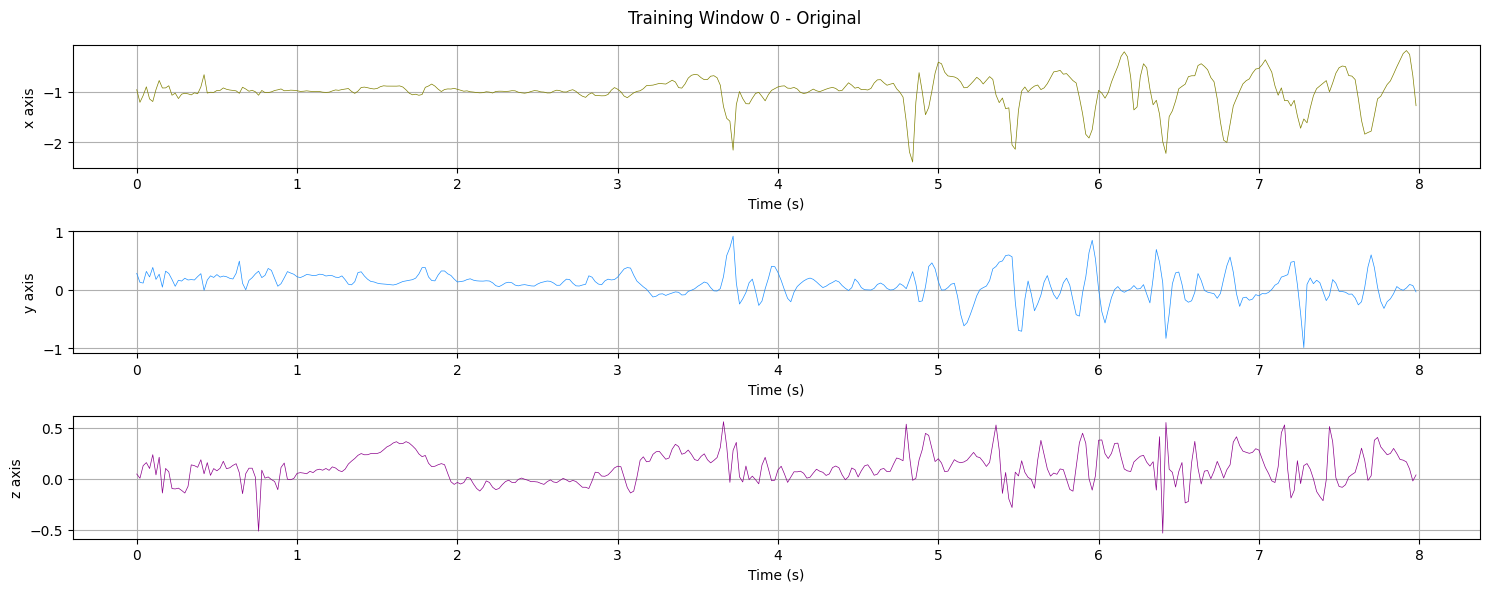

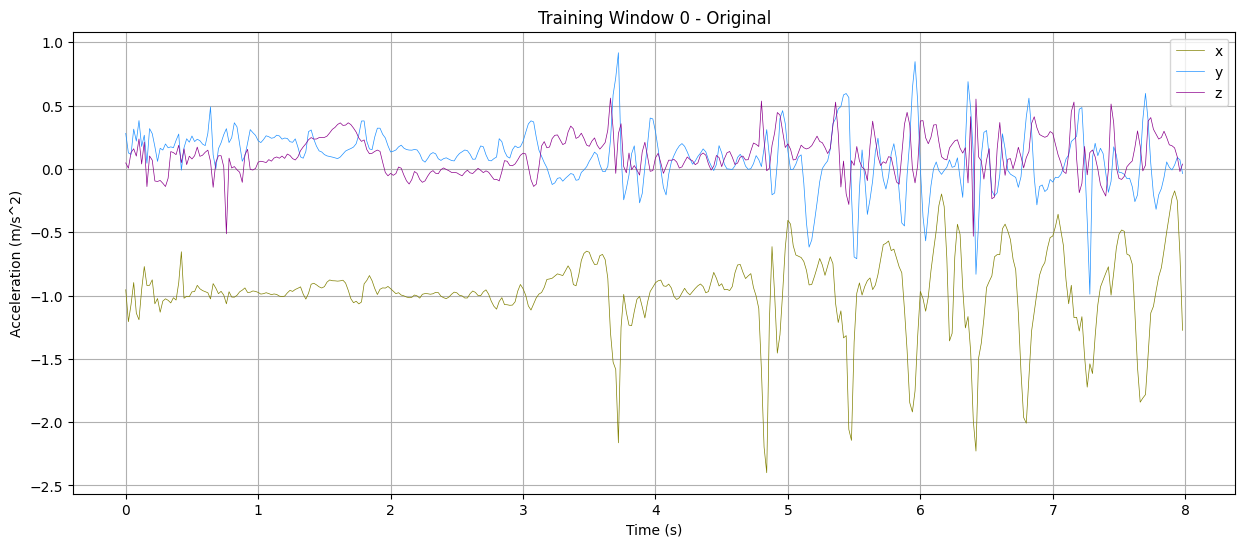

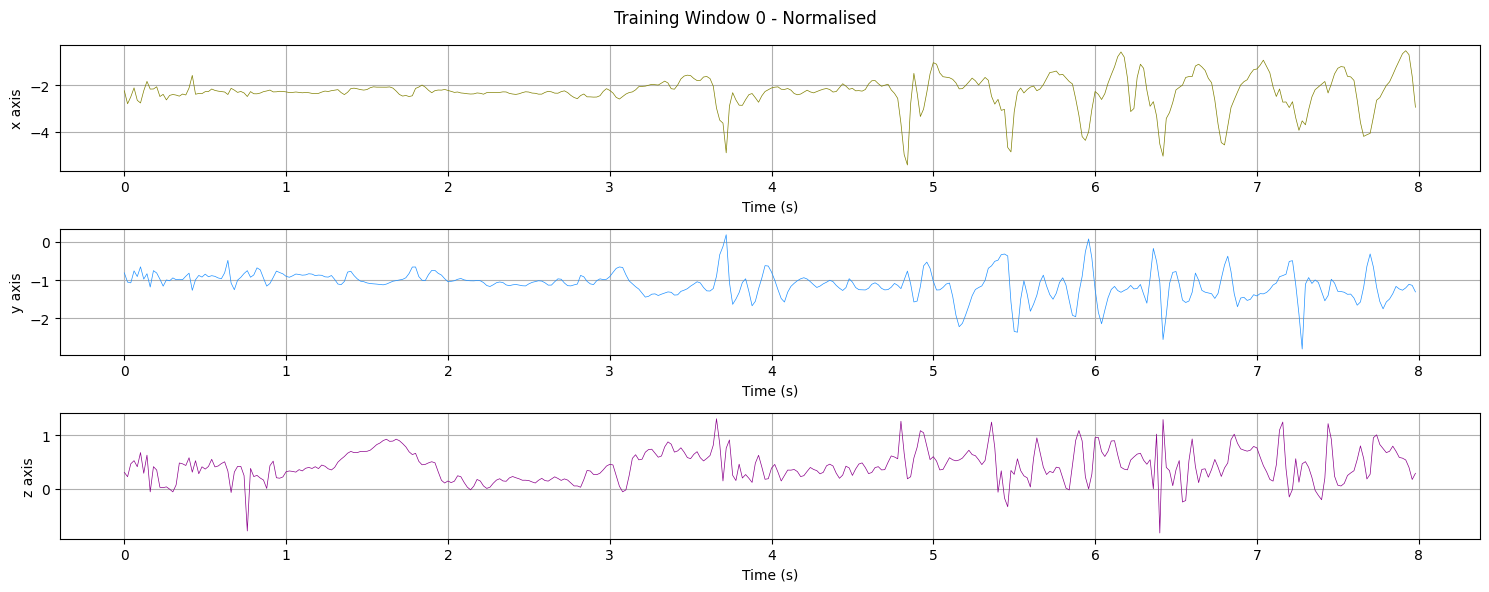

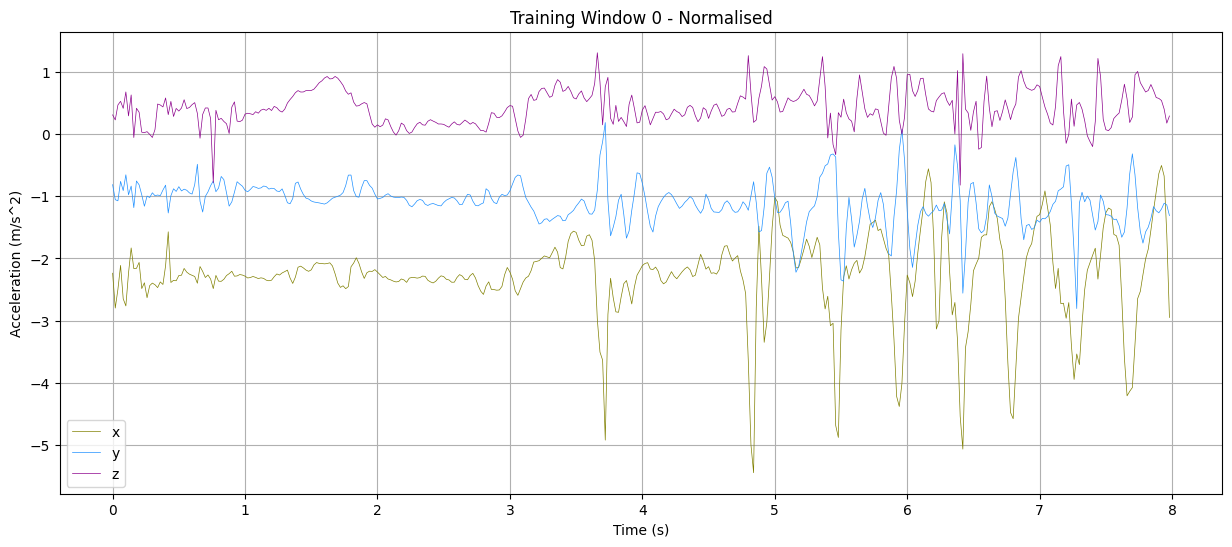

In [21]:
plot_accelerometer_timeseries(train_x[0], f"Training Window 0 - Original")
plot_accelerometer_timeseries(train_x_norm[0], f"Training Window 0 - Normalised")

### Label Encoding

Next we encode the labels, which are strings, into integers, so that they can be used for training.

In [22]:
def apply_label_map(y, label_map):
    """
    Apply a dictionary mapping to an array of labels
    Can be used to convert str labels to int labels
    Parameters:
        y
            1D array of labels
        label_map
            a label dictionary of (label_original -> label_new)
    Return:
        y_mapped
            1D array of mapped labels
            None values are present if there is no entry in the dictionary
    """

    y_mapped = []

    for l in y:
        y_mapped.append(label_map.get(l))

    return np.array(y_mapped)

In [23]:
label_map = dict([(l, i) for i, l in enumerate(label_list)])
output_shape = len(label_list)

train_y_mapped = apply_label_map(train_y, label_map)
test_y_mapped = apply_label_map(test_y, label_map)

In [24]:
print("Mapping")
for label, label_index in label_map.items():
    print(f"{label} --> {label_index}")

Mapping
dws --> 0
jog --> 1
sit --> 2
std --> 3
ups --> 4
wlk --> 5


In [25]:
print("Original:", train_y[::1000])
print("Mapped:  ", train_y_mapped[::1000])

Original: ['dws' 'wlk' 'sit' 'wlk' 'std' 'sit']
Mapped:   [0 5 2 5 3 2]


### Training & Validation Split

Finally we randomly split the training set further into training and validation set, where the validation set is used to tune the hyperparameters

In [26]:
# We use 10% of training data for validation
validation_split_proportion = 0.1

In [27]:
train_x_split, val_x_split, train_y_split, val_y_split = sklearn.model_selection.train_test_split(train_x_norm,
                                                                                                  train_y_mapped,
                                                                                                  test_size = validation_split_proportion,
                                                                                                  random_state = 42)

In [28]:
print("Original training set size:", train_x_norm.shape, train_y.shape)
print("Split training set size:   ", train_x_split.shape, train_y_split.shape)
print("Validation set size:       ", val_x_split.shape, val_y_split.shape)

Original training set size: (5211, 400, 3) (5211,)
Split training set size:    (4689, 400, 3) (4689,)
Validation set size:        (522, 400, 3) (522,)


In [29]:
train_set = (train_x_split, train_y_split)
val_set   = (val_x_split, val_y_split)
test_set  = (test_x_norm, test_y_mapped)

In [30]:
print(test_set[0].shape, test_set[1].shape)

(1419, 400, 3) (1419,)


### Visualise Label Distributions

1.2❓ Visualise the label distributions in the training, validation, and test data. Briefly discuss the implications, if any, that the distributions you visualise may have on the model training. [5]

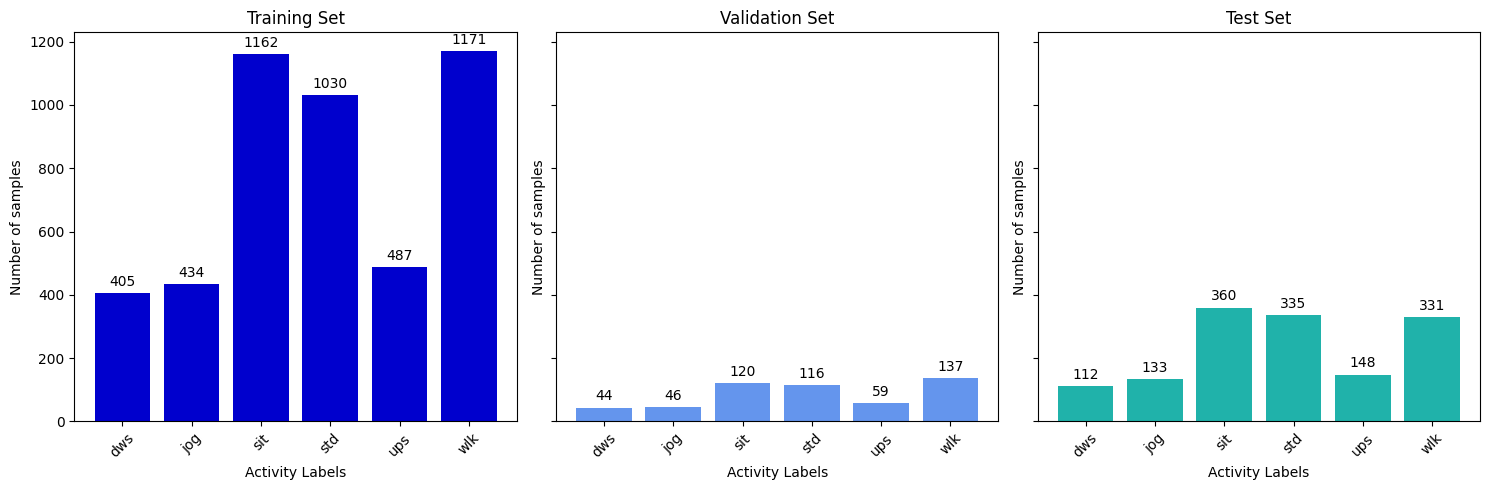

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(train_set, val_set, test_set, label_map, normalized=True):
    colors = ['mediumblue','cornflowerblue','lightseagreen']
    # Concatenate all labels from the training, validation, and test sets
    all_labels_train = train_set[1]
    all_labels_val = val_set[1]
    all_labels_test = test_set[1]

    # Count the occurrences of each label in each dataset
    label_counts_train = [np.sum(all_labels_train == label_index) for label_index in range(len(label_map))]
    label_counts_val = [np.sum(all_labels_val == label_index) for label_index in range(len(label_map))]
    label_counts_test = [np.sum(all_labels_test == label_index) for label_index in range(len(label_map))]

    # Get the total number of samples in each dataset
    total_samples_train = len(all_labels_train)
    total_samples_val = len(all_labels_val)
    total_samples_test = len(all_labels_test)

    # Normalize the label counts by the total number of samples in each dataset
    label_freq_train = [count / total_samples_train for count in label_counts_train]
    label_freq_val = [count / total_samples_val for count in label_counts_val]
    label_freq_test = [count / total_samples_test for count in label_counts_test]

    # Get the labels from the label_map
    labels = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]

    # Plotting
    if normalized:
        fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey='row')
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey='row')

    # Plot absolute counts and relative counts
    for i, (label_counts, label_freq, title) in enumerate(zip([label_counts_train, label_counts_val, label_counts_test],
                                                              [label_freq_train, label_freq_val, label_freq_test],
                                                              ['Training Set', 'Validation Set', 'Test Set'])):
        
        
        if normalized:
            # Plot absolute counts
            rects1 = axs[0, i].bar(labels, label_counts, color=colors[i])
            axs[0, i].set_title(f'{title}')
            # Plot relative counts
            rects2 = axs[1, i].bar(labels, [round(count * 100, 2) for count in label_freq], color=colors[i])
            axs[1, i].set_title(f'{title} - Normalized Distribution')

        # Add counts above the bars
            for rect in rects1 :
                height = rect.get_height()
                axs[0, i].annotate('{}'.format(height),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')
            for rect in rects2:
                height = rect.get_height()
                axs[1, i].annotate('{}'.format(height),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')
        else:
            # Plot absolute counts
            rects1 = axs[i].bar(labels, label_counts, color=colors[i])
            axs[i].set_title(f'{title}')
            for rect in rects1 :
                height = rect.get_height()
                axs[i].annotate('{}'.format(height),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')


    # Set common labels and rotation for all subplots
    for ax in axs.flat:
        ax.set_xlabel('Activity Labels')
        ax.set_ylabel('Number of samples')
        ax.set_xticks(np.arange(len(labels)))  # Set the tick positions
        ax.set_xticklabels(labels, rotation=45)  # Set the tick labels

    plt.tight_layout()
    plt.show()

train_set = (train_x_split, train_y_split)
val_set = (val_x_split, val_y_split)
test_set = (test_x_norm, test_y_mapped)

label_map_reverse = {v: k for k, v in label_map.items()}
plot_label_distribution(train_set, val_set, test_set, label_map,False)


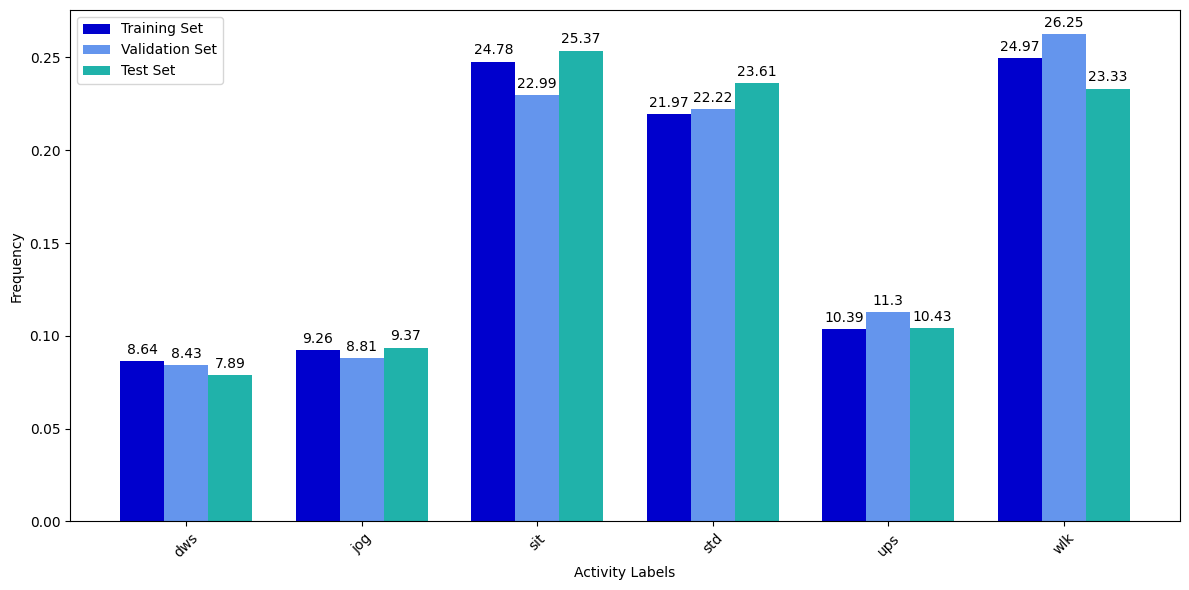

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_relative_label_distribution(train_set, val_set, test_set, label_map):

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height * 100, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    colors = ['mediumblue','cornflowerblue','lightseagreen']
    datasets = ['Training Set', 'Validation Set', 'Test Set']
    # Concatenate all labels from the training, validation, and test sets
    all_labels_train = train_set[1]
    all_labels_val = val_set[1]
    all_labels_test = test_set[1]

    # Count the occurrences of each label in each dataset
    label_counts_train = [np.sum(all_labels_train == label_index) for label_index in range(len(label_map))]
    label_counts_val = [np.sum(all_labels_val == label_index) for label_index in range(len(label_map))]
    label_counts_test = [np.sum(all_labels_test == label_index) for label_index in range(len(label_map))]

    # Get the total number of samples in each dataset
    total_samples_train = len(all_labels_train)
    total_samples_val = len(all_labels_val)
    total_samples_test = len(all_labels_test)

    # Normalize the label counts by the total number of samples in each dataset
    label_freq_train = [count / total_samples_train for count in label_counts_train]
    label_freq_val = [count / total_samples_val for count in label_counts_val]
    label_freq_test = [count / total_samples_test for count in label_counts_test]
    frequencies = [label_freq_train,label_freq_val,label_freq_test]
    # Get the labels from the label_map
    labels = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.25
    index = np.arange(len(labels))

    for i in range(3):
        rects1 = ax.bar(index + i*bar_width, frequencies[i], bar_width, color=colors[i], label=labels[i])
        autolabel(rects1)
   
    ax.set_xlabel('Activity Labels')
    ax.set_ylabel('Frequency')
    #ax.set_title('Relative Label Distribution')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labels)
    handles, previous_labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, loc='upper left',labels=datasets)

    

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
train_set = (train_x_split, train_y_split)
val_set = (val_x_split, val_y_split)
test_set = (test_x_norm, test_y_mapped)


plot_relative_label_distribution(train_set, val_set, test_set, label_map)


# Q2: Building and Training a Fully Supervised Deep Learning Model
[15 marks]

This question focuses on training a fully-supervised deep learning model for multi-class classification. It uses the train, test, and validation split from Q1.

2.1❓ Train the model provided and show and explain the results on the test data. Investigate the history object to find the accuracy and loss statistics found in both the training and the validation data and plot them. [5]

2.2❓ Obtain the predicted labels from the model's predictions on the test data. Then calculate the F1 score and plot the confusion matrix. Feel free to also report and discuss additional metrics, but reason about the metrics you show. [5]

2.3❓ Discuss the shortcomings of fully supervised methods in real-world applications. Hint: labelling wearable samples is a key challenge. [5]

### Building a Supervised Neural Network

Here we build a simple classifier model with three 1D-convolution layers (interleaved with dropout layers), a global maximum pooling layer, followed by two additional fully-connected layers.


> Reference (TPN model):
> Saeed, A., Ozcelebi, T., & Lukkien, J. (2019). Multi-task self-supervised learning for human activity detection. Proceedings of the ACM on Interactive, Mobile, Wearable and Ubiquitous Technologies, 3(2), 1-30.

In [33]:
unique_labels, class_counts = np.unique(train_y, return_counts = True)
num_classes = np.size(unique_labels)   # Number of classes in the data

**Important:** Do not change the model's implementation, as it is used for all questions of this assignment.

In [34]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape = input_shape, name = 'input'),
        tf.keras.layers.Conv1D(32, 24, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l = 1e-4)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv1D(64, 16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l = 1e-4)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv1D(96, 8, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l = 1e-4)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.GlobalMaxPool1D(data_format = 'channels_last', name = 'global_max_pooling1d'),
        tf.keras.layers.Dense(1000, activation = 'relu'),
        tf.keras.layers.Dense(num_classes),
        tf.keras.layers.Softmax()
    ])

    return model

In [35]:
model = create_model(train_x.shape[1:], num_classes)
model.summary()

2024-03-07 20:14:39.030519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 20:14:39.226548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 20:14:39.227244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 377, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 355, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 355, 96)           0         
                                                                 
 global_max_pooling1d (Glob  (None, 96)                0

### Training the Supervised Neural Network

In [36]:


optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003)

model.compile(optimizer = optimizer,
              loss      = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics   = [['accuracy']])

In [37]:
history = model.fit(x               = train_set[0],
                    y               = train_set[1],
                    validation_data = val_set,
                    batch_size      = 256,
                    shuffle         = True,
                    epochs          = 30)

Epoch 1/30


2024-03-07 20:14:45.160377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-07 20:14:48.217962: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdbf4da39d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 20:14:48.218043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-03-07 20:14:48.253285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709842488.596689 1306798 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - 10s 97ms/step - loss: 1.2887 - accuracy: 0.5246 - val_loss: 0.8328 - val_accuracy: 0.7912
Epoch 2/30
19/19 [==============================] - 1s 36ms/step - loss: 0.4363 - accuracy: 0.8705 - val_loss: 0.2338 - val_accuracy: 0.9157
Epoch 3/30
19/19 [==============================] - 1s 43ms/step - loss: 0.1976 - accuracy: 0.9405 - val_loss: 0.1208 - val_accuracy: 0.9655
Epoch 4/30
19/19 [==============================] - 1s 41ms/step - loss: 0.1129 - accuracy: 0.9687 - val_loss: 0.0478 - val_accuracy: 0.9962
Epoch 5/30
19/19 [==============================] - 1s 52ms/step - loss: 0.0594 - accuracy: 0.9874 - val_loss: 0.0504 - val_accuracy: 0.9866
Epoch 6/30
19/19 [==============================] - 1s 41ms/step - loss: 0.0446 - accuracy: 0.9904 - val_loss: 0.0367 - val_accuracy: 0.9962
Epoch 7/30
19/19 [==============================] - 1s 44ms/step - loss: 0.0588 - accuracy: 0.9868 - val_loss: 0.0495 - val_accuracy: 0.9885
Epoch 8/30
19/19 [=====

### Visualising the Training History

2.1❓ Train the model provided and show and briefly explain the results. Investigate the `history` object to find the accuracy and loss statistics of both the training and the validation data and plot them. [5]

Hint:  Here we want to visualise the training and validation accuracy, as well as the training and validation loss as the model is being trained. These statistics are stored in the `history` object that is returned from calling `model.fit`.

1. Look into the `history.history` dictionary, what keys does it have?
2. Call `print(history.history.keys())` to show all the keys of the dictionary
3. Pass `history.history['TRAIN_KEY'], history.history['VAL_KEY']` to the plotting function to complete the task
4. Have a look at the official reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

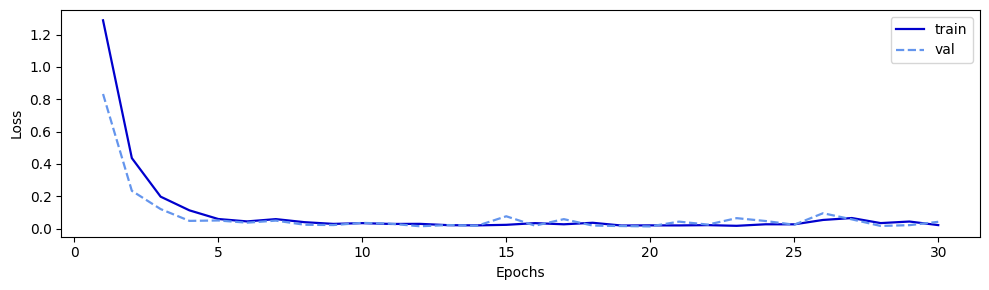

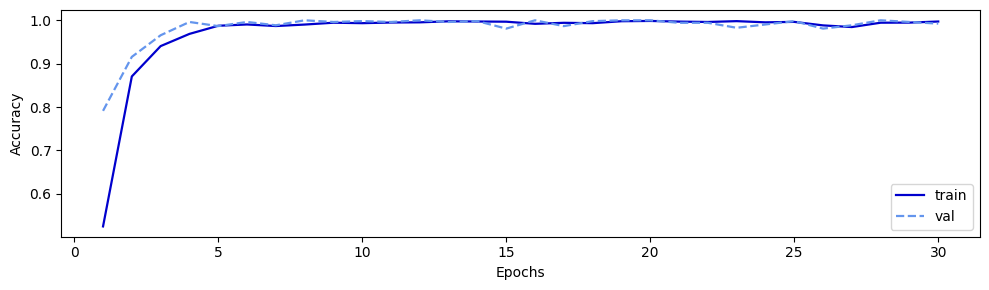

In [38]:

# Your code goes here
# ['loss', 'accuracy', 'val_loss', 'val_accuracy']
def plot_history(history):
    linewidth = 1.6
    fig_size = (10,3)
    linestyle = 'dashed'
    epochs = range(1, len(history['val_loss']) + 1)
    colors = ['mediumblue', 'cornflowerblue', 'lightseagreen']

    # First figure for Loss
    plt.figure(figsize=fig_size)
    plt.plot(epochs, history['loss'], colors[0], label='train', linewidth=linewidth)
    plt.plot(epochs, history['val_loss'], colors[1], label='val',linewidth=linewidth,linestyle=linestyle)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
   # plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Second figure for Accuracy
    plt.figure(figsize=(fig_size))
    plt.plot(epochs, history['accuracy'], colors[0], label='train',linewidth=linewidth)
    plt.plot(epochs, history['val_accuracy'], colors[1], label='val',linewidth=linewidth,linestyle=linestyle)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
   # plt.title('Training and Validation Accuracy')
    plt.legend()
    #plt.ylim([0, 1])  # Set y-axis limit from 0 to 1 for accuracy plot
    plt.tight_layout()
    plt.show()


plot_history(history.history)


### Evaluating the Supervised Model's Success

#### Using TensorFlow's Function

Here we can evaluate the model's performance using the built in `model.evaluate` function, by passing testing data and testing labels to the model. We can get the accuracy (in addition to the loss) of the model in this case because we have specified the metric to be accuracy only when we call `model.compile`.

In [39]:
performance = model.evaluate(x = test_set[0], y = test_set[1])

print(''.join([f"{name} = {value:.05f}  " for name, value in zip(model.metrics_names, performance)]))

45/45 [==============================] - 1s 13ms/step - loss: 0.6422 - accuracy: 0.8978
loss = 0.64218  accuracy = 0.89782  


#### Using a Custom Evaluation

2.2❓ Obtain the predicted labels from the model's predictions on the test data. Then calculate the F1 score and plot the confusion matrix. Feel free to also report and discuss additional metrics, but reason about the metrics you show. [5]

Hint:
Using functions from the sklearn.metrics module, we can easily extract [other performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) like the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

1. Obtain probabilistic predictions using  `model.predict(X)`
2. Obtain the integer labels of the predictions using `np.argmax(pred, axis = ?)`
  - Be mindful on which axis you are taking the argmax, is it 0 or 1?
  - Check the resulting length of the array to verify
3. Obtain F1 score and confusion matrix by completing the `sklearn.metrics` function calls
4. Plot the confusion matrix

In [89]:
# Your code goes here
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning) # because of precision score

def evaluate(model,test_set):
    logits = model.predict( test_set[0])
    predictions = np.argmax(logits, axis = 1)
    y_true = test_set[1]

    f1 = f1_score(y_true, predictions, average='weighted')
    f1_macro = f1_score(y_true, predictions, average='macro')
    recall = recall_score(y_true, predictions, average='weighted')
    precision = precision_score(y_true, predictions, average='weighted')
    accuracy = accuracy_score(y_true, predictions)
    balanced_accuracy = balanced_accuracy_score(y_true, predictions)
    print(f"F1 Score: {f1},F1 Score macro: {f1_macro}, Recall: {recall}, Precision: {precision}, Accuracy: {accuracy}, balanced Acc {balanced_accuracy}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, predictions)
    return conf_matrix

conf_matrix = evaluate(model,test_set)

45/45 [==============================] - 0s 4ms/step
F1 Score: 0.8991575830701334,F1 Score macro: 0.8599507903601888, Recall: 0.897815362931642, Precision: 0.9075228055094873, Accuracy: 0.897815362931642, balanced Acc 0.8628837840805165


Confusion matrix, without normalization


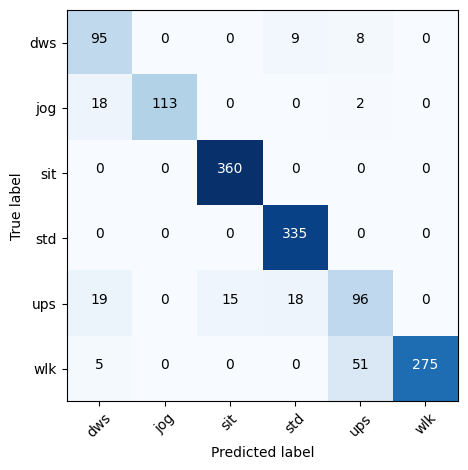

Normalized confusion matrix


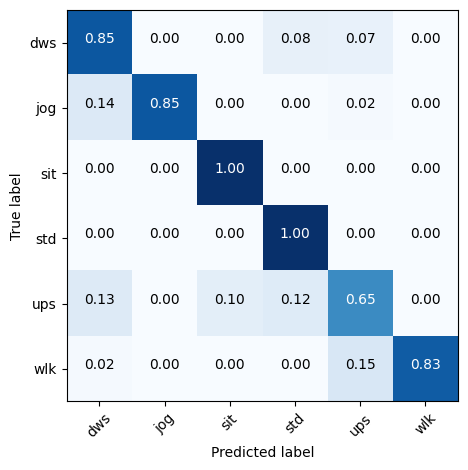

In [41]:
def plot_confusion_matrix(cm,
                          label_map,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes  = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matrix, label_map)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_matrix, label_map, normalize=True)



# Q3: Semi-Supervised Learning with Self-Training
[35 marks]

For this question, your task is to implement and train a Semi-Supervised Self-Training model and understand its key functionality.

3.1❓ Implement a Self-Training model using the given code as your foundation. Ensure that high-probability samples are pseudo-labelled by adding them to the labelled pool of data and removing them from the unlabelled pool of data at each iteration. Fill in the missing parts of the code to complete the implementation, but do not change the percentage of samples labelled or any other model parameters/layers. [15]

3.2❓ Report on your solution's results. Plot the training accuracy and loss statistics stored in the relavant `accuracy_history` and `loss_history` arrays during the algorithm's runtime to show that the training is meaningful and has converged. Also re-use the custom evaluation you implemented for Q2 to calculate the relevant metrics and report them accordingly. [5]

3.3❓ Report, compare, and reason about the diagnostic results against those achieved in Q2. What does this indicate for a real-world Self-Training solution? Is there any trade-off in performance and, if so, how significant is it? Under what circumstances may one of the solutions be preferred over the other? Discuss. [15]

### Label 20% (1/5th) of the Samples from the Training Set

In [42]:
labels_number    = int(train_set[0].shape[0] / 5)

X_label, y_label = train_set[0][:labels_number], train_set[1][:labels_number]
X_unlabeled     = train_set[0][labels_number:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


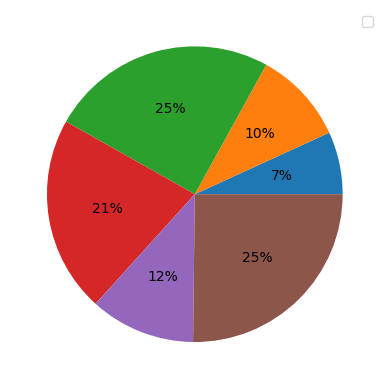

In [43]:
unique_labels, class_counts = np.unique(y_label, return_counts = True)

# Visualise amount of samples in each class
plt.figure()
plt.pie (class_counts, autopct = '%0.0f%%') # labels = label_name,
plt.legend()
plt.show()

### Creating and Training a Self-Training Model

In [44]:
iteration        = 0

loss_history     = []
accuracy_history = []

num_classes      = np.size(unique_labels) # Number of classes in the data

In [45]:
X_label.shape

(937, 400, 3)

In [46]:
X_unlabeled.shape

(3752, 400, 3)

In [49]:
y_label.shape

(937,)

3.1❓ Implement and train a Self-Training model using the given code as your foundation. Ensure that high-probability samples are pseudo-labelled by adding them to the labelled pool of data and removing them from the unlabelled pool of data at each iteration. Fill in the missing parts of the code to complete the implementation, but do not change the percentage of samples labelled or any other model parameters/layers. Please note that you have to keep track of the performance history in the relevant lists. [15]

Hint: a Self-Training solution uses pseudo-labelling as follows:
- It iteratively predicts labels for unlabelled data and adds high-confidence predictions to the labelled pool
- The threshold of what consists a high-confidence prediction can be adjusted based on the dataset, but a good choice would be 95%
- The newly-(pseudo)-labelled samples are combined with the initial labelled set at each iteration and the model is retrained until convergence

In [51]:
threshold = 0.95
iteration = 0
epochs = 10
early_stopping = 10
assigned = True
X_label, y_label = train_set[0][:labels_number], train_set[1][:labels_number]
X_unlabeled     = train_set[0][labels_number:]
stopping = 0
histories = None

while (stopping <= early_stopping and len(X_unlabeled) != 0 ):
    print('Self-Training Iteration:', iteration)
    assigned = False
    new_unlabeled = []
    pseudo_labeled_X = []
    pseudo_labeled_y = []

    # Here we re-use the same model creation function implemented for the fully-supervised setting from Q2
    model = create_model(train_x.shape[1:], num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003)
    
    # Your code goes here
    model.compile(optimizer = optimizer,
              loss      = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics   = [['accuracy']])
    history = model.fit(X_label, y_label, validation_data = val_set, verbose = 0, batch_size = 256, epochs = epochs)
    if histories is None:
        histories = dict.fromkeys(history.history.keys())
        for key in histories.keys():
            histories[key] = []
    for key in histories.keys():
        histories[key].append(history.history[key][-1])

    ###
    probabilities = model.predict( X_unlabeled)
    max_prob_index = np.argmax(probabilities, axis=-1)
    max_prob_value = np.max(probabilities, axis=-1)
    for x,proba,label in zip(X_unlabeled,max_prob_value,max_prob_index):
        if threshold <= proba:
            assigned = True
            pseudo_labeled_X.append(x)
            pseudo_labeled_y.append(label)
        else:
            new_unlabeled.append(x)
    if not assigned:
        print(f'Early Stopping activated: {stopping}/{early_stopping}')
        stopping += 1
        
    X_unlabeled = np.array(new_unlabeled)
    if len(pseudo_labeled_X) != 0:
        X_label = np.concatenate((X_label,np.array(pseudo_labeled_X)),axis=0)
        y_label = np.concatenate((y_label,np.array(pseudo_labeled_y)),axis=0)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    iteration += 1
    #

Self-Training Iteration: 0


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f591ca6ab90>
Traceback (most recent call last):
  File "/home/lw754/L349/.conda/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


118/118 [==============================] - 1s 3ms/step
598 unlabeled instances remaining.

Self-Training Iteration: 1


KeyboardInterrupt: 

### Training Self-Training Model on Final Labelled Dataset

In [ ]:
# Train the model
model = create_model(X_label.shape[1:], num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003)
model.compile(optimizer = optimizer,
              loss      = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics   = [['accuracy']])
training_history = model.fit(X_label, y_label, validation_data = val_set, verbose = 1, batch_size = 256, epochs = 20)
for key in histories.keys():
        histories[key].append(training_history.history[key][-1])
# Keep track of the performance history
# Your code goes here
#
#
#

Epoch 1/20
19/19 [==============================] - 3s 44ms/step - loss: 1.0170 - accuracy: 0.6266 - val_loss: 0.3870 - val_accuracy: 0.8314
Epoch 2/20
19/19 [==============================] - 0s 24ms/step - loss: 0.2753 - accuracy: 0.8990 - val_loss: 0.1719 - val_accuracy: 0.9617
Epoch 3/20
19/19 [==============================] - 0s 24ms/step - loss: 0.1180 - accuracy: 0.9665 - val_loss: 0.1134 - val_accuracy: 0.9770
Epoch 4/20
19/19 [==============================] - 0s 24ms/step - loss: 0.0733 - accuracy: 0.9818 - val_loss: 0.0917 - val_accuracy: 0.9808
Epoch 5/20
19/19 [==============================] - 0s 23ms/step - loss: 0.0548 - accuracy: 0.9870 - val_loss: 0.1624 - val_accuracy: 0.9617
Epoch 6/20
19/19 [==============================] - 0s 23ms/step - loss: 0.0621 - accuracy: 0.9842 - val_loss: 0.1455 - val_accuracy: 0.9732
Epoch 7/20
19/19 [==============================] - 0s 23ms/step - loss: 0.0495 - accuracy: 0.9887 - val_loss: 0.1005 - val_accuracy: 0.9828
Epoch 8/20
19

### Visualising the Training History

3.2❓ Report on your solution's results. Plot the training accuracy and loss statistics stored in the relavant `accuracy_history` and `loss_history` arrays during the algorithm's runtime to show that the training is meaningful and has converged. Also re-use the custom evaluation you implemented for Q2 to calculate the relevant metrics and report them accordingly. [5]

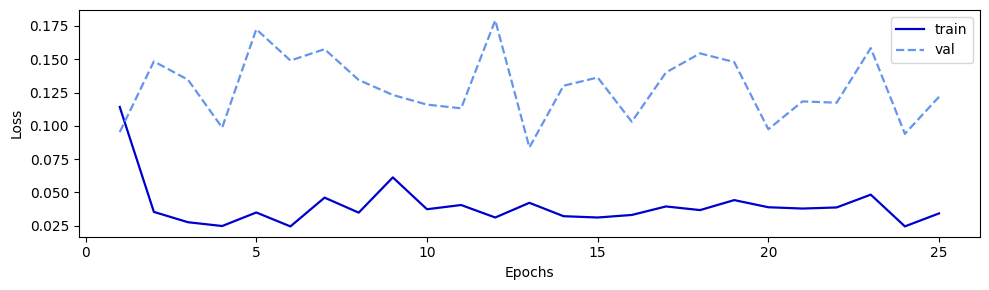

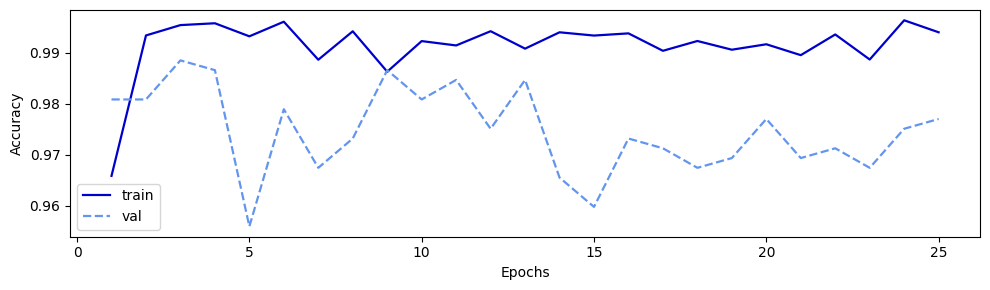

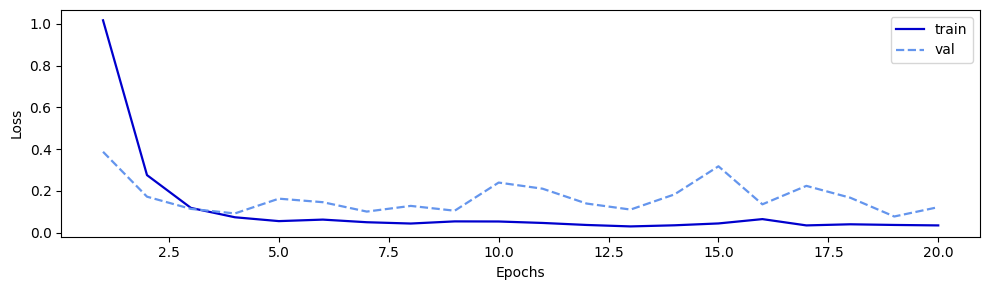

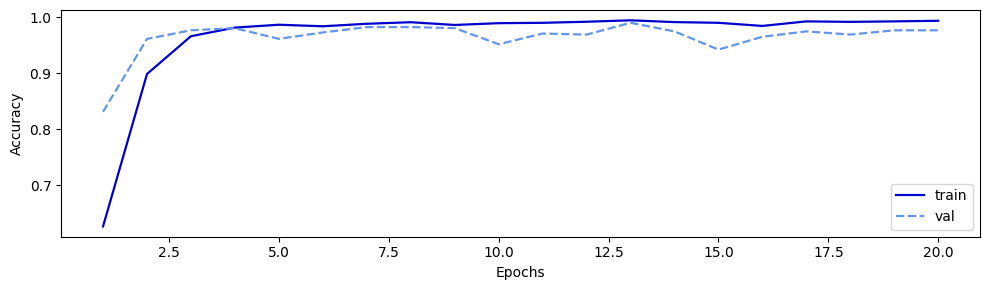

In [ ]:
plot_history(histories)


### Evaluating Model's Success

#### Using TensorFlow's Function

Here we can evaluate the model's performance using the built in `model.evaluate` function, by passing testing data and testing labels to the model. We can get the accuracy (in addition to the loss) of the model in this case because we have specified the metric to be accuracy only when we call `model.compile`.

In [ ]:
performance = model.evaluate(x = test_set[0], y = test_set[1])

print(''.join([f"{name} = {value:.05f}  " for name, value in zip(model.metrics_names, performance)]))

45/45 [==============================] - 0s 6ms/step - loss: 0.3517 - accuracy: 0.8922
loss = 0.35173  accuracy = 0.89218  


#### Using a Custom Evaluation

Here please re-use the custom evaluation you implemented for **Q2** to calculate the relevant metrics and report them accordingly.

45/45 [==============================] - 0s 3ms/step
F1 Score: 0.8970755117419247,F1 Score macro: 0.8565162016674711, Recall: 0.8921775898520085, Precision: 0.9158612044052663, Accuracy: 0.8921775898520085, balanced Acc 0.869440348595421
Confusion matrix, without normalization


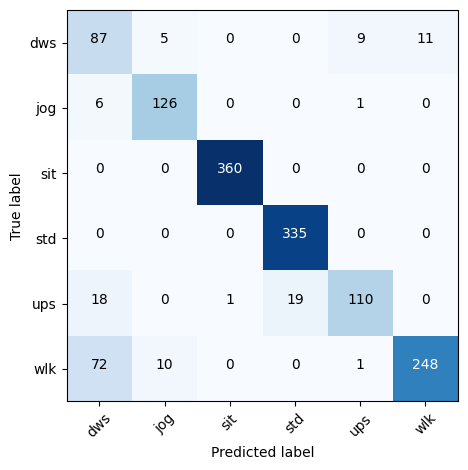

Normalized confusion matrix


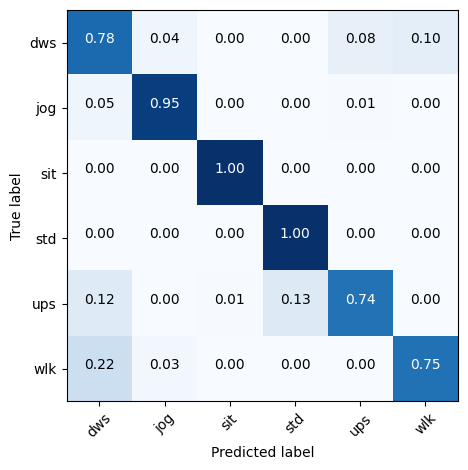

In [ ]:
# Your code goes here
conf_matrix = evaluate(model,test_set)
# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matrix, label_map)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_matrix, label_map, normalize=True)

# Q4: Further Exploration of Semi-Supervised Learning with Self-Training
[Exclusively for Part II students] [40 marks]

For this question, your task is to re-use the code of **Q3** and experiment with different label percentages and the trade-offs that these bring.

4.1 ❓ Try different percentages of labelled data (i.e. other than 20% - 1/5th of the dataset that you used in Q3) and extract the metrics from Q3 that you see fit. As a minimum, you should report the accuracy and loss on the test set. **Important:** do not alter your answer/implementation for Q3, but re-code the relevant parts in the cells of this question. [20]

4.2 ❓ Plot and create a relevant comparative table, showing the results against the percentage of labels to identify and show at which percentage the training is most meaningful and has converged in the optimal combination. [5]

4.3 ❓ Discuss how class imbalance might have affected your results. How would you address this issue? [5]

4.4 ❓ Report, discuss, and reason about the results, using appropriate paper references and doing your own indepent research as well. Hint: remember that runtime and the fact that the labels would be supplied by a human user in the real world are key factors to consider [10]



In [ ]:
# Your code goes here

# Q5: Semi-Supervised Learning with a Mean-Teacher Model
[Exclusively for Part III/MPhil/CDT students] [40 marks]

For this question, your task is to implement and explore a Mean-Teacher Semi-Supervised Learning algorithm, while also doing your own research.

5.1❓ Implement and train the Mean-Teacher algorithm. Also plot the training history and clearly communicate all your results and metrics in the report. [20]

5.2❓ Explore which settings affect the model performance the most (other than the model structure / model layers themselves) and discuss. Plot and create a relevant comparative table to support your findings. Hint: focus on the label percentage and the perturbation functions. [15]

5.3❓ Do your independent research on Semi-Supervised Learning methods and discuss challenges when deploying them in a real-world application. Also examine what alternative Semi-Supervised solutions you could have used, including relevant references to back your claim. [5]

### Creating and Training a Mean-Teacher Model

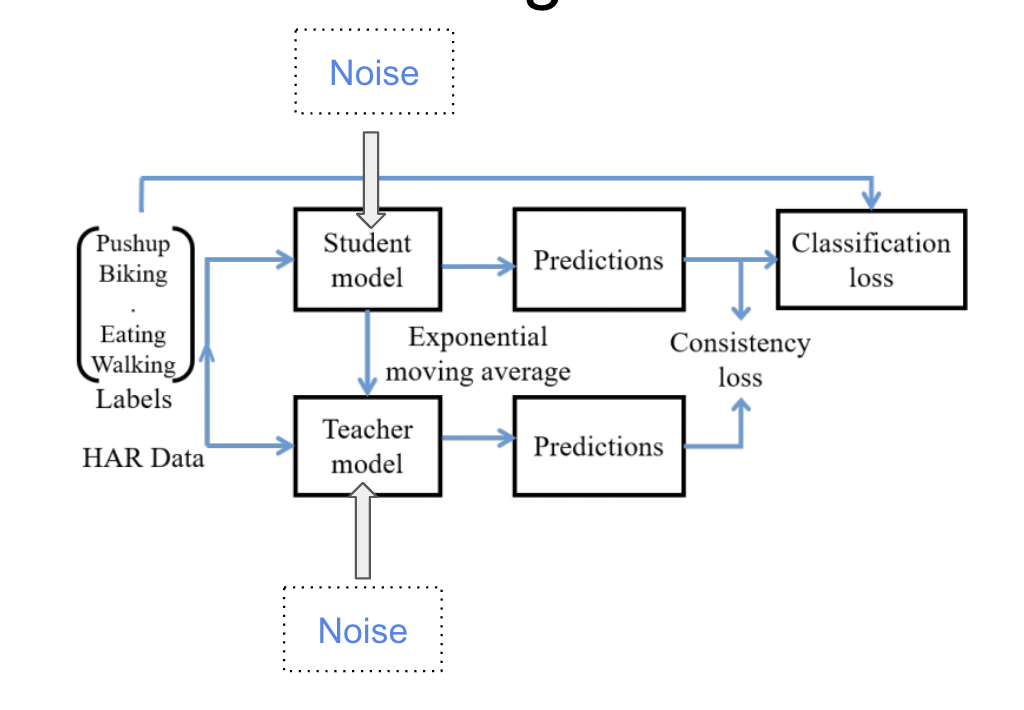

**Training process:**


*   The HAR dataset with both labeled and unlabeled samples are randomly selected as a mini-batch.
*   These batches of data are then feed into both the student and teacher models. With noise added on the data and model.


*   For the labeled samples, the classification loss is computed as the cross-entropy between the predictions of student model and the ground truth.
*   For the unlabeled data, the mean-square distance between the prediction from the student and teacher models are used as the consistency loss.

**Optimizing process:**

*  Only the weights of student model is updated the weights of the teacher model are the Exponential Moving Average (EMA) of the weights from student model.

> Reference :
> Narasimman, Govind et al. “A*HAR: A New Benchmark towards Semi-supervised learning for Class-imbalanced Human Activity Recognition.” ArXiv abs/2101.04859 (2021): n. pag.








Here we can decide what percentage of labels will be provided to the model before the mean-teacher algorithm takes over.

Here we choose the batch size, epochs, learning rate, optimiser, and alpha values. **Important:** please do not change these, but proceed with your implementation using them.

Re-use the same model creation function implemented for the fully-supervised setting in **Q2**.

In [93]:
# Here we use 20% labels (i.e. 1/5th of the training set)
data_set_size      = train_set[0].shape[0]
labels_number      = num_labels_kept = int(data_set_size / 5)

X_labeled          = train_set[0][:labels_number]
Y_labeled          = train_set[1][:labels_number]
X_pseudo_unlabeled = train_set[0][labels_number:]

input_shape   = (train_set[0].shape[1], train_set[0].shape[2])
num_classes   = np.size(unique_labels)


batch_size = 64
epochs     = 30
lrate      = 0.003
alpha      = 0.99                                    # Exponential moving average factor

number_of_labeled_samples = 4
steps = epochs * (data_set_size // batch_size)

batch_size_unlabeled = batch_size - number_of_labeled_samples
labeled_dataset              = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled)).shuffle(len(X_labeled)).batch(number_of_labeled_samples)
unlabeled_dataset = tf.data.Dataset.from_tensor_slices((X_pseudo_unlabeled)).shuffle(len(X_pseudo_unlabeled)).batch(batch_size_unlabeled)




In [94]:
# Data perturbation function
def add_gaussian_noise(data, stddev = 0.01):
    noise = tf.random.normal(shape = tf.shape(data), mean = 0., stddev = stddev,dtype=data.dtype)
    return data + noise

# Model perturbation function
def perturb_model_weights(model, stddev = 0.0001):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv1D):  # Adjust as needed
            weights, biases = layer.get_weights()
            weights += tf.random.normal(shape = weights.shape, mean = 0., stddev = stddev)
            layer.set_weights([weights, biases])

5.1❓ Implement and train the Mean-Teacher algorithm. Also plot the training history and clearly communicate all your results and metrics in the report. [20]

In [99]:


def custom_loss_function(y_true,y_predict, unlabeled_teacher_logits, unlabeled_student_logits):
    consistency_loss = tf.keras.metrics.mean_squared_error(unlabeled_student_logits, unlabeled_teacher_logits)
    classification_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_predict)
    # Compute gradients for student model
    loss = tf.reduce_mean(tf.concat([consistency_loss, classification_loss], axis=0))
    return loss

def calc_accuracy(y_true,y_predict):
    predictions = np.argmax(y_predict, axis = 1)
    accuracy = accuracy_score(y_true, predictions)
    return accuracy

def update_ema_weights(student, teacher, ema_decay):
    ema_weights = teacher.get_weights()
    student_weights = student.get_weights()
    for i in range(len(student_weights)):
            ema_weights[i] = ema_decay * ema_weights[i] + (1.0 - ema_decay) * student_weights[i]
    return ema_weights

def eval_val(history,student_model,val_set,train_accs,train_losses):
    if np.array(train_accs).size != 0:
        train_loss = np.mean(train_losses)
        train_acc = np.mean(train_accs)
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        #val
        student_model.compile(optimizer = optimizer, loss=  tf.keras.losses.sparse_categorical_crossentropy, metrics   = [['accuracy']])
        loss, acc = student_model.evaluate(val_set[0], val_set[1],verbose=0)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(acc)
    return history            

def train_semi_supervised(steps,batch_size,labeled_dataset,unlabeled_dataset,val_set, perturb_model_weights_stddev, add_gaussian_noise_stddev):
    student_model = create_model(input_shape, num_classes)
    teacher_model = create_model(input_shape, num_classes)
    optimizer  = tf.keras.optimizers.Adam(learning_rate = lrate)    # Example optimizer
    optimizer.build(student_model.trainable_variables)
    teacher_model.set_weights(student_model.get_weights())
    
    metrics = ['loss','accuracy','val_loss','val_accuracy']
    history =  {key : [] for key in metrics}
    losses = []
    accs = []

    for step in tqdm(range(steps)):
        total_loss = 0
        labeled_loss = 0
        consistency_loss = 0
        # print(f'Step {step+1}/{steps}')#
        labeled_sample = next(iter(labeled_dataset.shuffle(buffer_size=1000).take(1)))
        unlabeled_sample = next(iter(unlabeled_dataset.shuffle(buffer_size=1000).take(1)))
        
        # Extract tensors from the samples
        labeled_X, y = labeled_sample
        number_labeled_samples_batchs = y.shape[0]
        unlabeled_X = unlabeled_sample
        
        # Concatenate the samples
        batch_X = tf.concat([labeled_X, unlabeled_X], axis=0)
        
        # Now you can apply noise and other operations to new_batch_X
        batch_X = add_gaussian_noise(batch_X,add_gaussian_noise_stddev)

        perturb_model_weights(student_model,perturb_model_weights_stddev)
        perturb_model_weights(teacher_model,perturb_model_weights_stddev)
        
        with tf.GradientTape() as tape:
            tape.watch(batch_X)
            student_logits = student_model(batch_X, training=True)
            teacher_logits = teacher_model(batch_X, training=False)

            # part of batch from unlabeled_dataset
            unlabeled_student_logits = student_logits[number_labeled_samples_batchs:]
            unlabeled_teacher_logits = teacher_logits[number_labeled_samples_batchs:]
            labeled_student_logits = student_logits[:number_labeled_samples_batchs]
            loss = custom_loss_function(y,labeled_student_logits, unlabeled_teacher_logits, unlabeled_student_logits)
            losses.append(loss)
            accs.append(calc_accuracy(y,labeled_student_logits))
            # print("Total Loss:", loss.numpy())
            gradients = tape.gradient(loss, student_model.trainable_variables)
        # Apply gradients using optimizer
        optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

        # Print out shapes of gradients and trainable variables
        ema_weights = update_ema_weights(student_model, teacher_model,ema_decay=alpha)   
        teacher_model.set_weights(ema_weights)

        if  (step + 1) % 20 == 0:
            history = eval_val(history,student_model,val_set,accs,losses)
            losses = []
            accs = []
    return eval_val(history,student_model,val_set,accs,losses), student_model, teacher_model
   
          




In [73]:
history, student_model, teacher_model = train_semi_supervised(steps,batch_size,labeled_dataset,unlabeled_dataset,val_set,perturb_model_weights_stddev=0.01, add_gaussian_noise_stddev=0.01)

100%|██████████| 146/146 [01:42<00:00,  1.43it/s]


In [104]:
# optimize number_of_labeled_samples, labels_number, perturb_model_weights, add_gaussian_noise
numbers_of_labeled_samples = [1,4,8,16,32,64]
labels_numbers = [100,20,10,5,2]
perturb_model_weights_stddevs = [0.1,0.01,0.001,0.0001, 0.00001]
add_gaussian_noise_stddevs = [0.1,0.01,0.001,0.0001, 0.00001]
save_dir = Path('/home/lw754/L349/results_task5')
steps = epochs * (data_set_size // batch_size)
steps = 13
results = {}

for label_number in labels_numbers:
    # make dataset  unlabeled and labeled
    labels_number      = num_labels_kept = int(train_set[0].shape[0] /label_number )
    X_labeled          = train_set[0][:labels_number]
    Y_labeled          = train_set[1][:labels_number]
    X_pseudo_unlabeled = train_set[0][labels_number:]

    for number_of_labeled_samples in numbers_of_labeled_samples:
        batch_size_unlabeled = batch_size - number_of_labeled_samples
        labeled_dataset              = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled)).shuffle(len(X_labeled)).batch(number_of_labeled_samples)
        unlabeled_dataset = tf.data.Dataset.from_tensor_slices((X_pseudo_unlabeled)).shuffle(len(X_pseudo_unlabeled)).batch(batch_size_unlabeled)

        for perturb_model_weights_stddev in perturb_model_weights_stddevs:
            for add_gaussian_noise_stddev in add_gaussian_noise_stddevs:
                run = f'RUN: label_number: {label_number}, number_of_labeled_samples_batch: {number_of_labeled_samples}, perturb_model_weights_stddev: {perturb_model_weights_stddev}, add_gaussian_noise_stddev: {add_gaussian_noise_stddev}'
                run_save_name = f'label_number_{label_number}_number_of_labeled_samples_batch_{number_of_labeled_samples}_perturb_model_weights_stddev_{perturb_model_weights_stddev}_add_gaussian_noise_stddev_{add_gaussian_noise_stddev}'
                print(run)
                history, student_model, teacher_model = train_semi_supervised(steps,batch_size,labeled_dataset,unlabeled_dataset,val_set,perturb_model_weights_stddev=perturb_model_weights_stddev, add_gaussian_noise_stddev=add_gaussian_noise_stddev)
                results[run] = [history, student_model, teacher_model]
                evaluate(teacher_model,val_set)
                print()
                # save results
                run_save_dir = save_dir/run_save_name
                run_save_dir.mkdir(parents=True, exist_ok=True)
                joblib.dump(student_model, run_save_dir/'student_model_weights.pkl')
                joblib.dump(teacher_model, run_save_dir/'teacher_model_weights.pkl')
                pd.DataFrame(history).to_csv(run_save_dir/'history_metrics.csv', index=False)


RUN: label_number: 100, number_of_labeled_samples_batch: 1, perturb_model_weights_stddev: 0.1, add_gaussian_noise_stddev: 0.1


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


17/17 [==============================] - 0s 3ms/step
F1 Score: 0.13889238602822893,F1 Score macro: 0.0898065382517101, Recall: 0.2567049808429119, Precision: 0.09520987393365637, Accuracy: 0.2567049808429119, balanced Acc 0.16558836540588365

RUN: label_number: 100, number_of_labeled_samples_batch: 1, perturb_model_weights_stddev: 0.1, add_gaussian_noise_stddev: 0.01


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


17/17 [==============================] - 0s 4ms/step
F1 Score: 0.11970103731259113,F1 Score macro: 0.07844761736882308, Recall: 0.26436781609195403, Precision: 0.07773701203647361, Accuracy: 0.26436781609195403, balanced Acc 0.17045454545454544

RUN: label_number: 100, number_of_labeled_samples_batch: 1, perturb_model_weights_stddev: 0.1, add_gaussian_noise_stddev: 0.001


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


17/17 [==============================] - 0s 3ms/step
F1 Score: 0.11110976574675283,F1 Score macro: 0.10141682455662128, Recall: 0.16091954022988506, Precision: 0.3818869105317303, Accuracy: 0.16091954022988506, balanced Acc 0.20191570881226054

RUN: label_number: 100, number_of_labeled_samples_batch: 1, perturb_model_weights_stddev: 0.1, add_gaussian_noise_stddev: 0.0001


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


17/17 [==============================] - 0s 4ms/step
F1 Score: 0.109956999074367,F1 Score macro: 0.06982670744138635, Recall: 0.2624521072796935, Precision: 0.06954727020757835, Accuracy: 0.2624521072796935, balanced Acc 0.16666666666666666

RUN: label_number: 100, number_of_labeled_samples_batch: 1, perturb_model_weights_stddev: 0.1, add_gaussian_noise_stddev: 1e-05


 69%|██████▉   | 9/13 [00:09<00:04,  1.02s/it]


KeyboardInterrupt: 

### Visualising the Training History

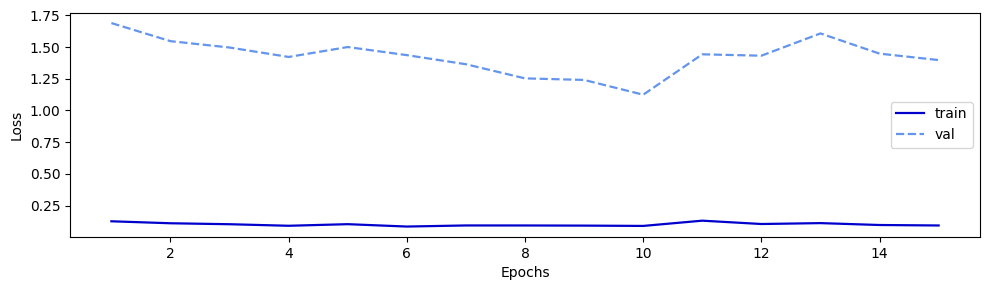

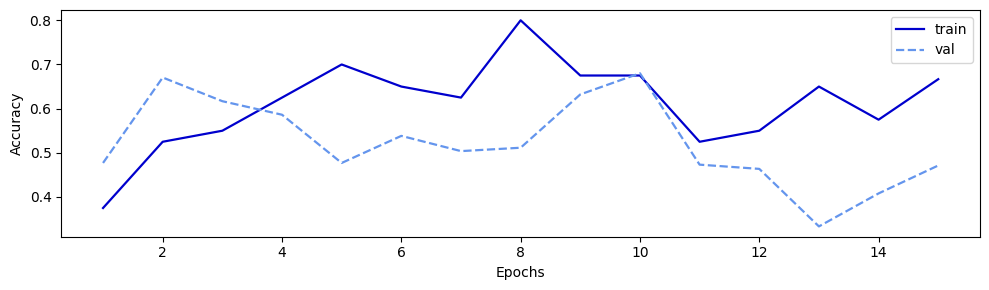

In [75]:
# Your code goes here
plot_history(history)

### Evaluating Model's Success

#### Using TensorFlow's Function

Here we can evaluate the model's performance using the built in `model.evaluate` function, by passing testing data and testing labels to the model. We can get the accuracy (in addition to the loss) of the model in this case because we have specified the metric to be accuracy only when we call `model.compile`.

In [73]:
# Evaluate the student model
student_model.compile(optimizer = optimizer, metrics   = [['accuracy']])

student_loss, student_accuracy = student_model.evaluate(test_set[0], test_set[1])
print(f"Student Model - Loss: {student_loss}, Accuracy: {student_accuracy}")

45/45 [==============================] - 0s 5ms/step - loss: 0.0216 - accuracy: 0.8421
Student Model - Loss: 0.021599337458610535, Accuracy: 0.8421423435211182


In [74]:
# Evaluate the teacher model
teacher_model.compile(optimizer = optimizer, metrics   = [['accuracy']])

teacher_loss, teacher_accuracy = teacher_model.evaluate(test_set[0], test_set[1])
print(f"Teacher Model - Loss: {teacher_loss}, Accuracy: {teacher_accuracy}")

45/45 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.8879
Teacher Model - Loss: 0.02071291208267212, Accuracy: 0.8879492878913879


#### Using a Custom Evaluation

Here please re-use the custom evaluation you implemented for **Q2** to calculate the relevant metrics and report them accordingly.

45/45 [==============================] - 0s 4ms/step
F1 Score: 0.6430217303383696,F1 Score macro: 0.6178694862319934, Recall: 0.6666666666666666, Precision: 0.7989922234079055, Accuracy: 0.6666666666666666, balanced Acc 0.6655673737543913
45/45 [==============================] - 0s 3ms/step
F1 Score: 0.04455805724304667,F1 Score macro: 0.030007030007030006, Recall: 0.04298801973220578, Precision: 0.1025571881204111, Accuracy: 0.04298801973220578, balanced Acc 0.029484521835268104
Confusion matrix, without normalization


/home/lw754/L349/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


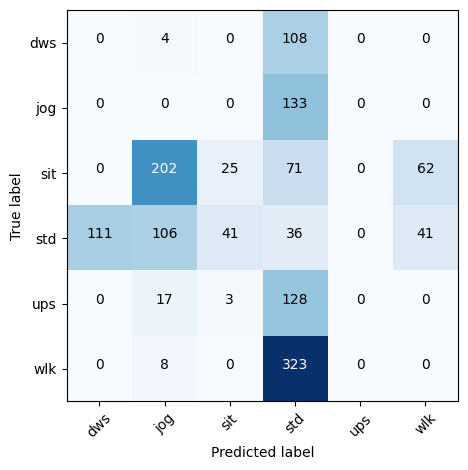

Normalized confusion matrix


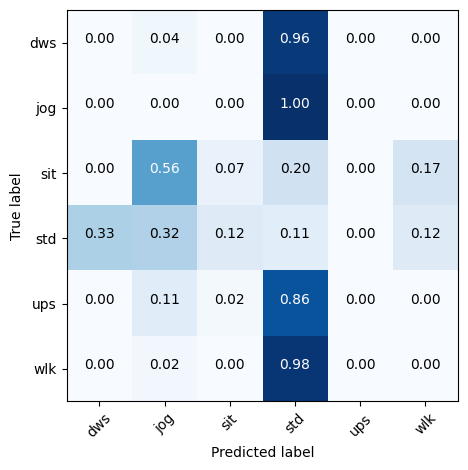

45/45 [==============================] - 0s 3ms/step
F1 Score: 0.04762438355048671,F1 Score macro: 0.08140144909975644, Recall: 0.11205073995771671, Precision: 0.04250697726773823, Accuracy: 0.11205073995771671, balanced Acc 0.19706360495834177
 1/45 [..............................] - ETA: 1s

/home/lw754/L349/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 [==============================] - 0s 3ms/step
F1 Score: 0.04455805724304667,F1 Score macro: 0.030007030007030006, Recall: 0.04298801973220578, Precision: 0.1025571881204111, Accuracy: 0.04298801973220578, balanced Acc 0.029484521835268104
Confusion matrix, without normalization


/home/lw754/L349/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


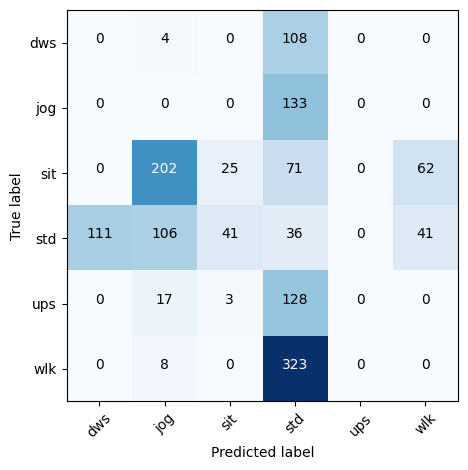

Normalized confusion matrix


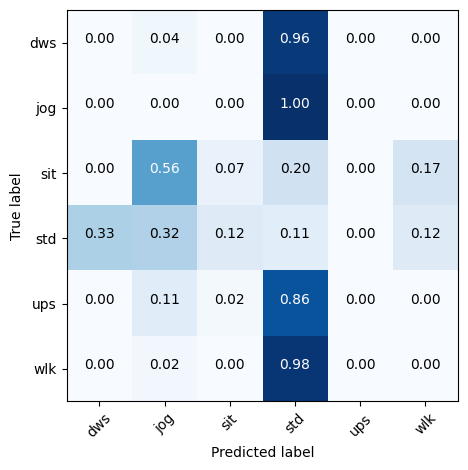

In [67]:
# Your code goes here
# student
conf_matrix = evaluate(student_model,test_set)
conf_matrix = evaluate(model,test_set)
plot_confusion_matrix(conf_matrix, label_map)
plot_confusion_matrix(conf_matrix, label_map, normalize=True)

#teacher
conf_matrix = evaluate(teacher_model,test_set)
conf_matrix = evaluate(model,test_set)
plot_confusion_matrix(conf_matrix, label_map)
plot_confusion_matrix(conf_matrix, label_map, normalize=True)

### Exploration and Discussion

5.2❓ Explore which settings affect the model performance the most (other than the model structure / model layers themselves) and discuss. Plot and create a relevant comparative table to support your findings. Hint: focus on the label percentage and the perturbation functions. [15]

5.3❓ Do your independent research on Semi-Supervised Learning methods and discuss challenges when deploying them in a real-world application. Also examine what alternative Semi-Supervised solutions you could have used, including relevant references to back your claim. [5]